In [3]:
library(pheatmap)
library(corrplot)
library(RColorBrewer)
library(tidyverse)
library(MASS)

In [4]:
MDS_Regression = function(dissim, DV, ndim=5, type_mds){
    if(type_mds == 'mds'){
        fit_mds_score_none = cmdscale(dissim,eig=TRUE,k=ndim)
    }
    if(type_mds == 'nmds'){
        fit_mds_score_none = isoMDS(as.matrix(dissim),k=ndim)
    }    
    
    # plot solution
    Dim1 = fit_mds_score_none$points[,1]
    Dim2 = fit_mds_score_none$points[,2]
    
    options(repr.plot.width=5, repr.plot.height=5)
    plot(Dim1, Dim2, xlab="Formality", ylab="Valence",main="mds", type="n")
    text(Dim1, Dim2, labels = row.names(dissim), cex=.6)
    
    # independent variable for regression 
    IV = fit_mds_score_none$points
    IV = as.data.frame(IV)
    IV_reorder = IV[rownames(DV),]
    
    count = 0
    for (i in seq(159)){
        if (rownames(DV)[i] == rownames(IV_reorder)[i]){
            count = count+1
        }
    }

    if (count == 159){
        coe_matrix = matrix(nrow = 30, ncol = 7)
        coe_df = as.data.frame(coe_matrix)
        row.names(coe_df) = colnames(DV)
        colnames(coe_df) = c('V1','V2','V3','V4','V5','R2','F')

        #Regression in each dimension
        for (i in seq(30)){
            if (ndim==5){
                fit = lm(DV[[i]]~IV_reorder$V1+IV_reorder$V2+IV_reorder$V3+IV_reorder$V4+IV_reorder$V5)
            }
            if (ndim==4){
                fit = lm(DV[[i]]~IV_reorder$V1+IV_reorder$V2+IV_reorder$V3+IV_reorder$V4)
            }
            if (ndim==2){
                fit = lm(DV[[i]]~IV_reorder$V1+IV_reorder$V2)
            }
            #print(colnames(DV)[i])
            #print(summary(fit))

            for (j in 1:ndim){
                coe_df[i,j] = fit$coefficients[j+1]
              }
              coe_df[i,6] = summary(fit)$r.square
              coe_df[i,7] = summary(fit)$fstatistic[1]
        }
    }
    
    #output
    result = list(coe_df = coe_df,
                  IV = IV)
    return(result)
}

Plot_coefficient = function(coe_df,ndim=5,task='Implicit'){
    options(repr.plot.width=6, repr.plot.height=6)
    loadings_none_reorder = coe_df[,1:ndim]

    #filter each row's max loading, and attribute it to correspnding column.
    order_list = c()
    for (row in c(1:30)){
        temp_max = abs(loadings_none_reorder[row,1])
        n = 1
        for (col in c(1:ndim)){
            temp = abs(loadings_none_reorder[row,col])
            if (temp > temp_max){
                temp_max = temp
                n = col
            }

        }
        order_list[row] = n
    }
    
    loadings_none_reorder = loadings_none_reorder %>% mutate(order = order_list) %>% arrange(order)
    
    if (ndim==2) {
        V1 = loadings_none_reorder %>% filter(order==1) %>% arrange(desc(V1))
        V2 = loadings_none_reorder %>% filter(order==2) %>% arrange(desc(V2))
        loadings_none_reorder = rbind(V1,V2)
        loadings_none_reorder = loadings_none_reorder[1:ndim]
        colnames(loadings_none_reorder) = c('V1','V2')
    }

    if (ndim==4) {
        V1 = loadings_none_reorder %>% filter(order==1) %>% arrange(desc(V1))
        V2 = loadings_none_reorder %>% filter(order==2) %>% arrange(desc(V2))
        V3 = loadings_none_reorder %>% filter(order==3) %>% arrange(desc(V3))
        V4 = loadings_none_reorder %>% filter(order==4) %>% arrange(desc(V4))
        loadings_none_reorder = rbind(V1,V2,V3,V4)
        loadings_none_reorder = loadings_none_reorder[1:ndim]
        colnames(loadings_none_reorder) = c('V1','V2','V3','V4')
    }
    
    if (ndim==5) {
        V1 = loadings_none_reorder %>% filter(order==1) %>% arrange(desc(V1))
        V2 = loadings_none_reorder %>% filter(order==2) %>% arrange(desc(V2))
        V3 = loadings_none_reorder %>% filter(order==3) %>% arrange(desc(V3))
        V4 = loadings_none_reorder %>% filter(order==4) %>% arrange(desc(V4))
        V5 = loadings_none_reorder %>% filter(order==5) %>% arrange(desc(V5))
        loadings_none_reorder = rbind(V1,V2,V3,V4,V5)
        loadings_none_reorder = loadings_none_reorder[1:ndim]
        colnames(loadings_none_reorder) = c('V1','V2','V3','V4','V5')
    }

    #title = paste(task,'76 rels')
#     loadings_plot = pheatmap(loadings_none_reorder,cluster_row = FALSE, cluster_col = FALSE,
#              color = colorRampPalette(rev(brewer.pal(n=7,name ="RdBu")))(100),
#              angle_col = '0',fontsize_col = 12, main=title)
    
    options(repr.plot.width=6, repr.plot.height=10)
    #my.breaks = c(seq(-1,1,by=0.01))
    corrplot(as.matrix(loadings_none_reorder),is.corr=FALSE,tl.col = "black",tl.srt=90,tl.cex=1,cl.ratio = 0.4,cl.cex=1,
             col = colorRampPalette(rev(brewer.pal(n=7,name ="RdBu")))(100))    
}

# Import data

In [5]:
# each participant's dimension model result
path_dim_raw = '../../output_data/individual/dimension/clean_results/dim_rel_scaled/'
subj_dim_list = dir(path_dim_raw)

i=0
dim_subj_paths = c()
for (subj in subj_dim_list){
    i = i+1
    dim_subj_paths[i] = paste(path_dim_raw,subj,sep='')
}

In [6]:
# Explicit task
path_exp_raw = '../../output_data/individual/category/Subject_Category_RDMs_revised/'

i=0
exp_subj_paths= c()
for (subj in subj_dim_list){
    i = i+1
    exp_subj_paths[i] = paste(path_exp_raw,subj,sep='')
}
paste(paste('Found',length(exp_subj_paths)),'subjects in explicit task.')
# Implicit task
path_imp_raw = '../../output_data/individual/category/Subject_MA_RDMs_revised/'

i=0
imp_subj_paths= c()
for (subj in subj_dim_list){
    i = i+1
    imp_subj_paths[i] = paste(path_imp_raw,subj,sep='')
}
paste(paste('Found',length(imp_subj_paths)),'subjects in implicit task.')

[1] "Found 14 subjects in explicit task."

[1] "Found 14 subjects in implicit task."

# Explicit task

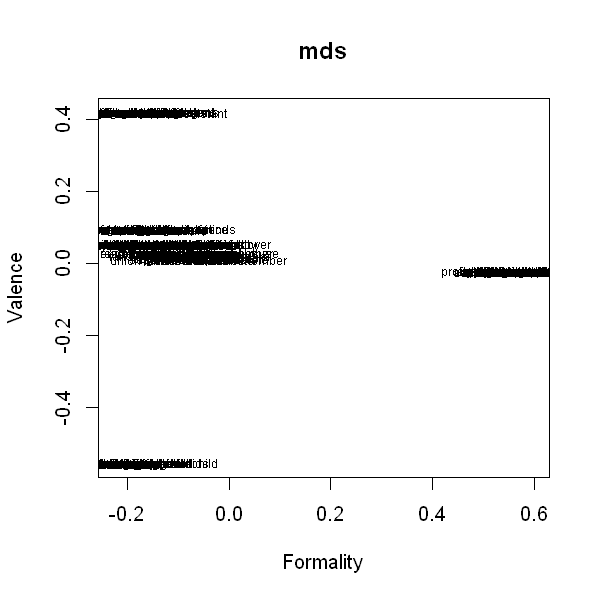

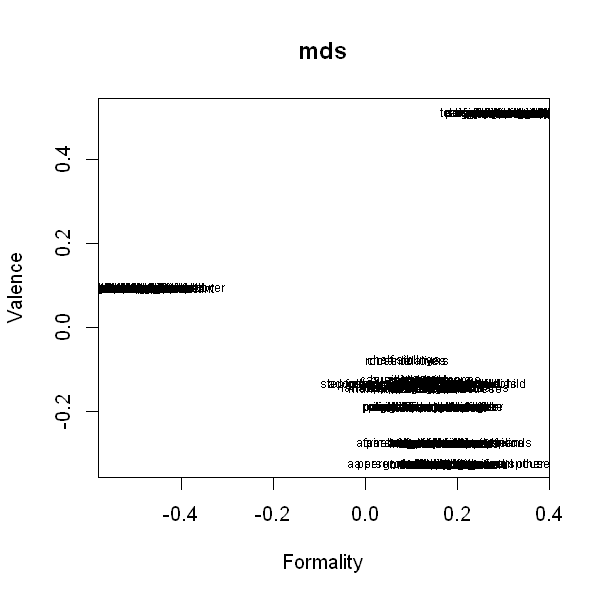

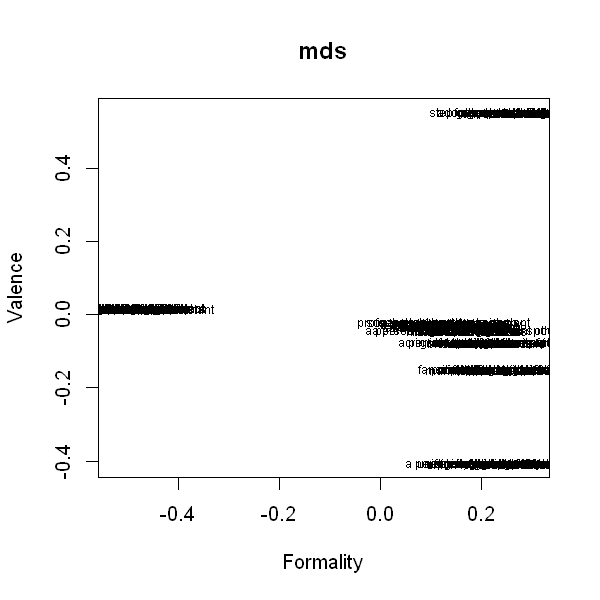

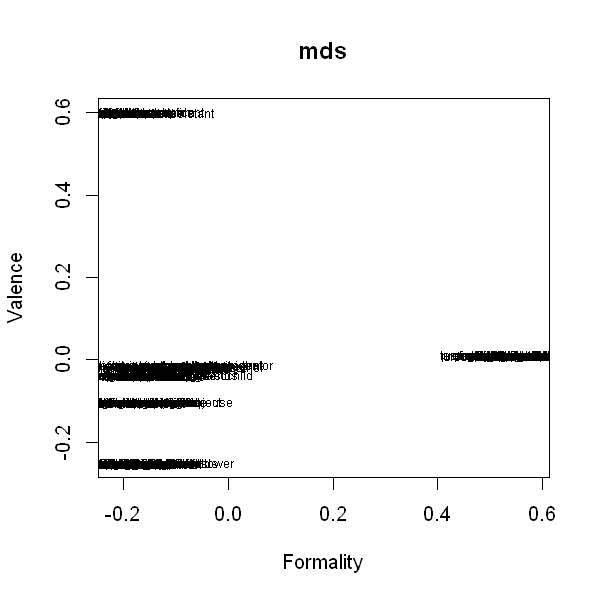

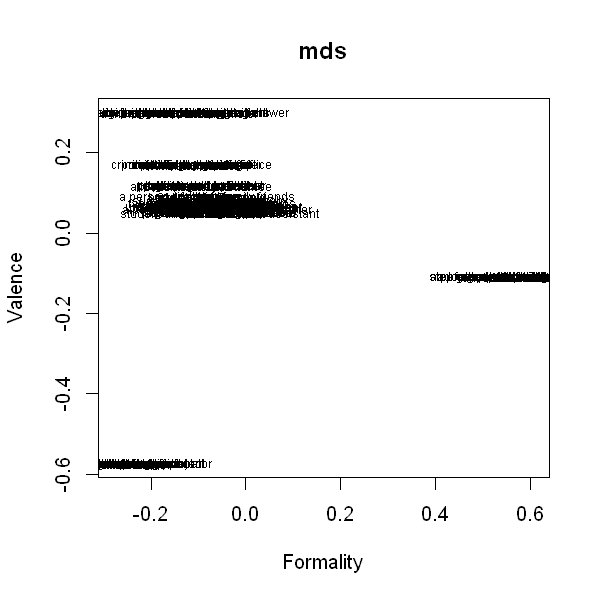

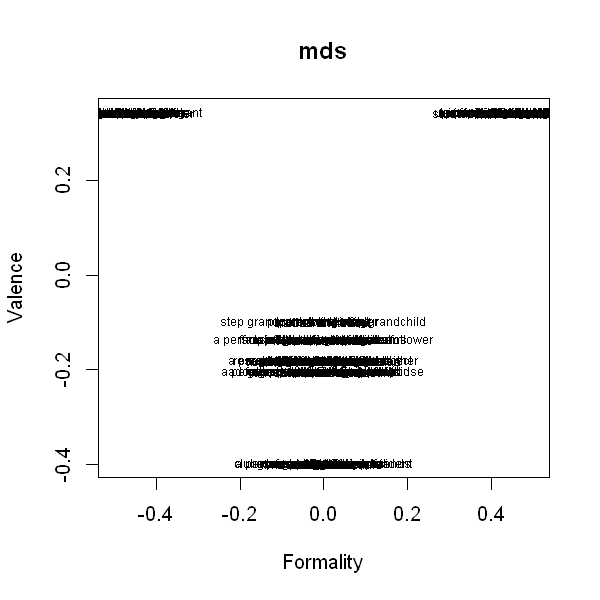

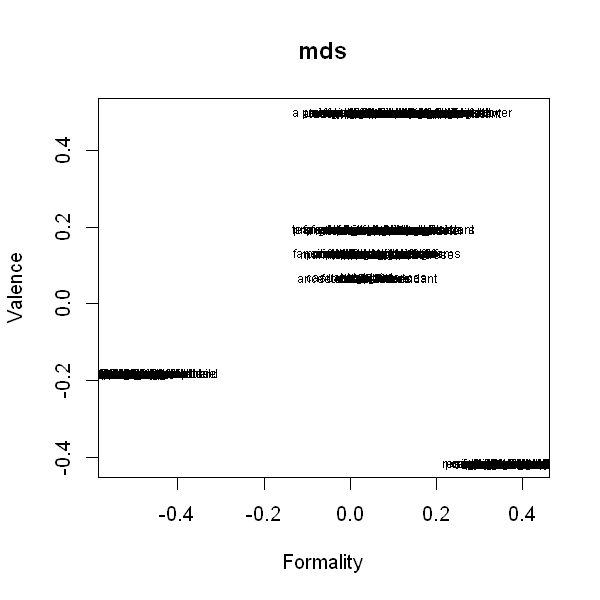

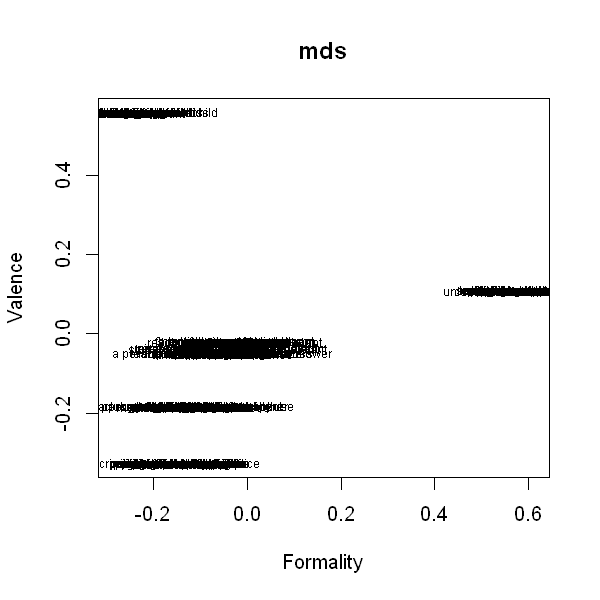

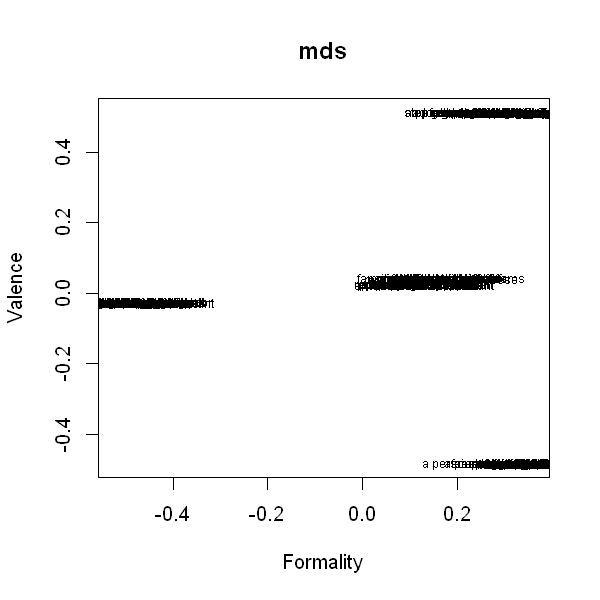

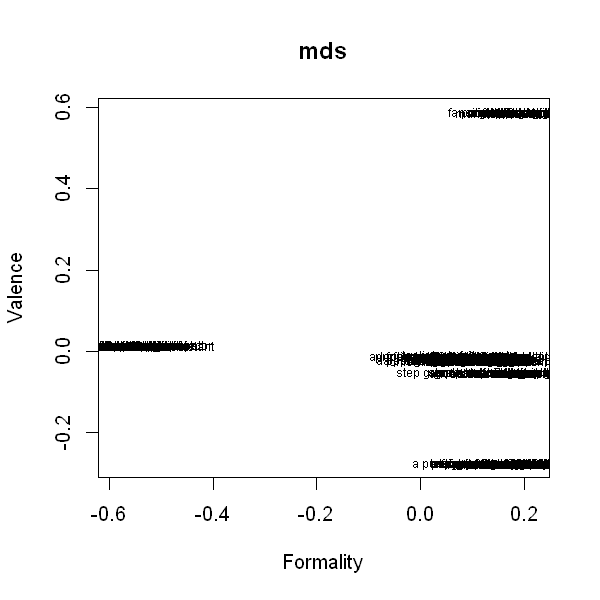

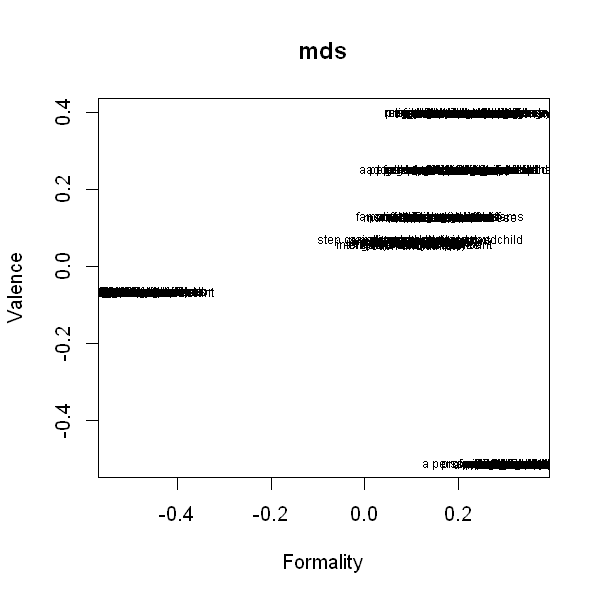

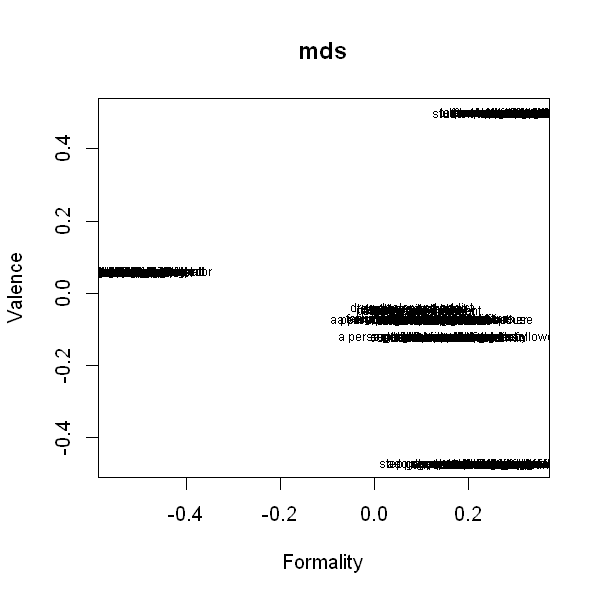

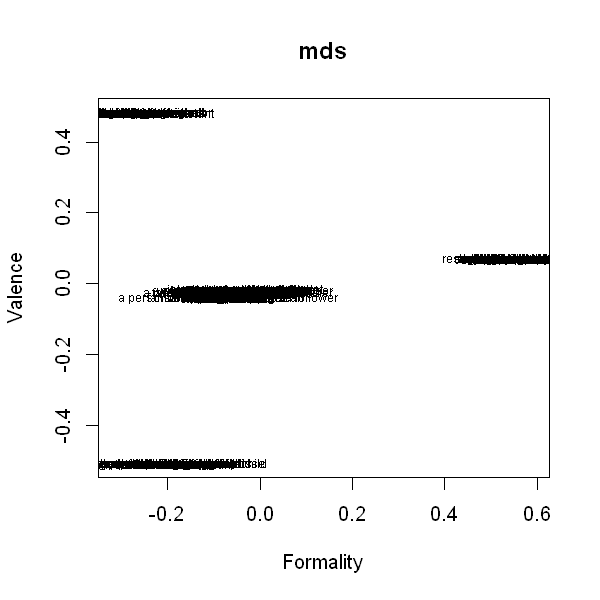

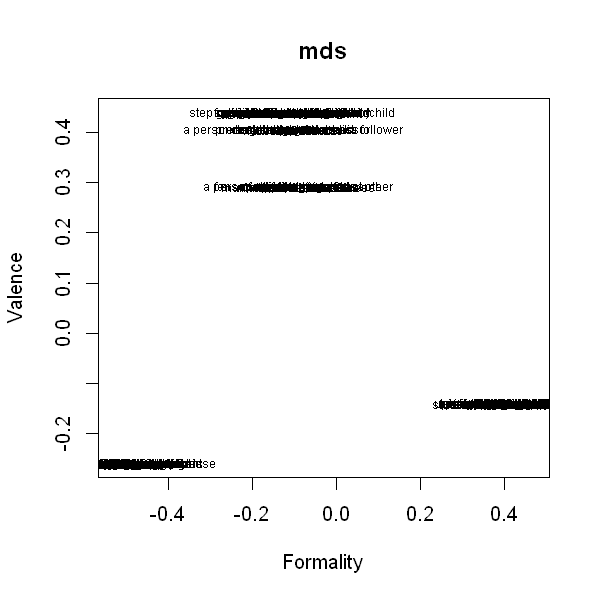

In [7]:
i = 0
for (f in exp_subj_paths){
    i = i+1
    exp_dissim = read.csv(f, row.names=1)
    DV_159 = read.csv(dim_subj_paths[i],row.names=1)
    
    mds_none = MDS_Regression(exp_dissim,DV_159,ndim=2,type_mds='mds')

    mds_coe_df = mds_none$coe_df
    mds_IV = mds_none$IV

    write.csv(mds_coe_df, file=paste('../../output_data/individual/category/dimension_results/exp_mds_2V_ind/loading_score_none/',subj_dim_list[i],sep=''))
    write.csv(mds_IV, file=paste('../../output_data/individual/category/dimension_results/exp_mds_2V_ind/relationship_score_none/',subj_dim_list[i],sep=''))
}

[1] "Found 14 subjects."

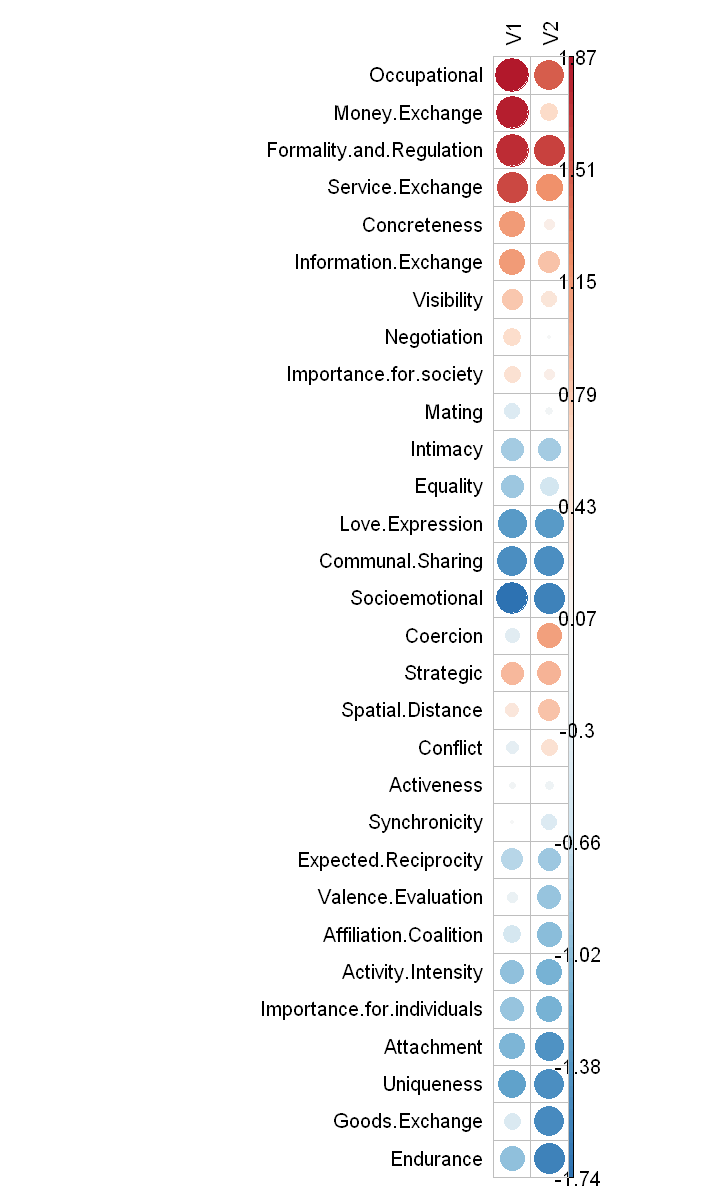

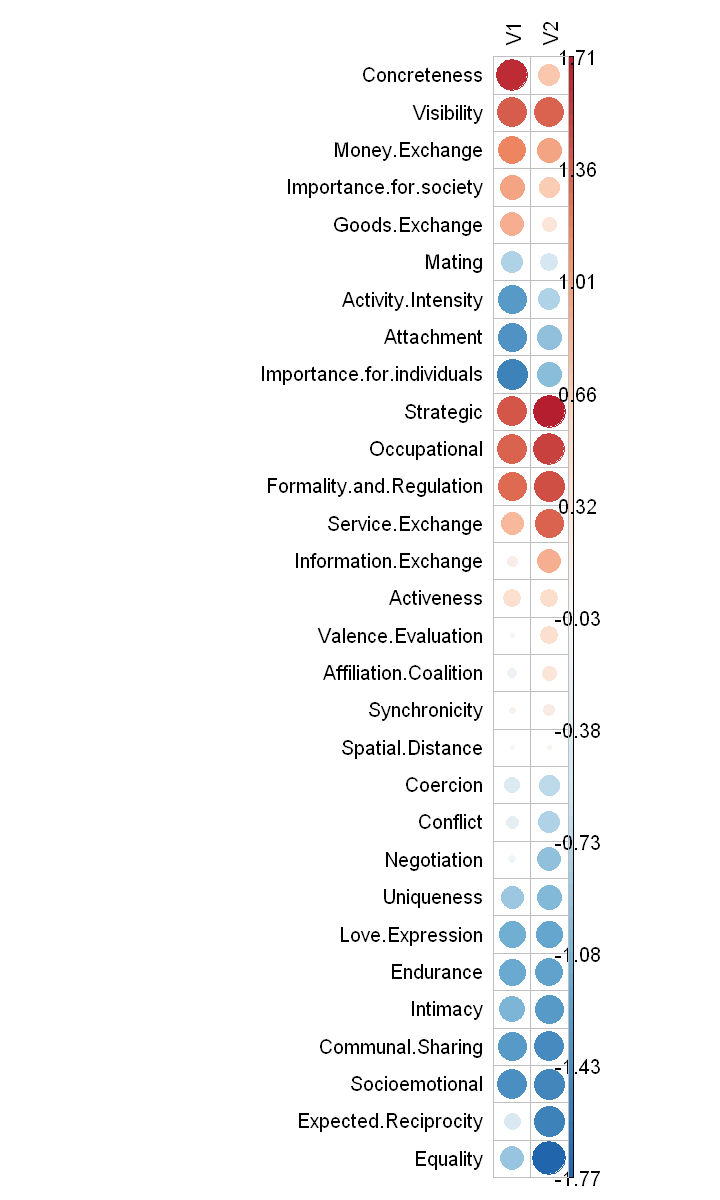

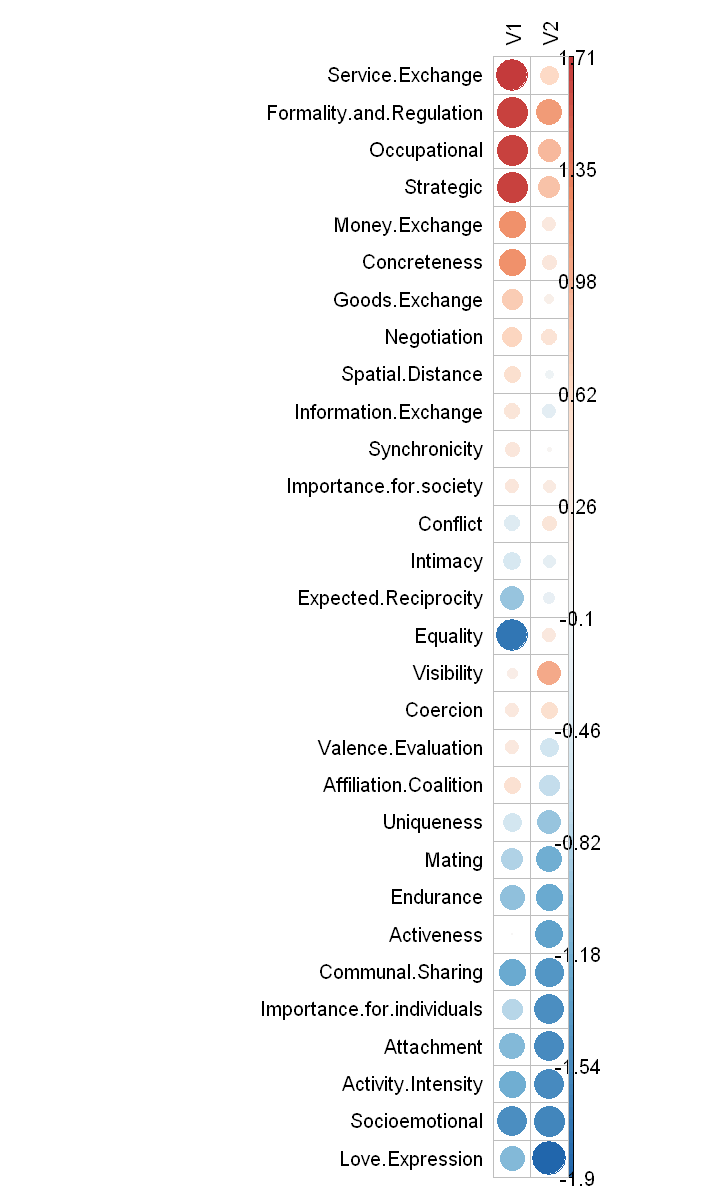

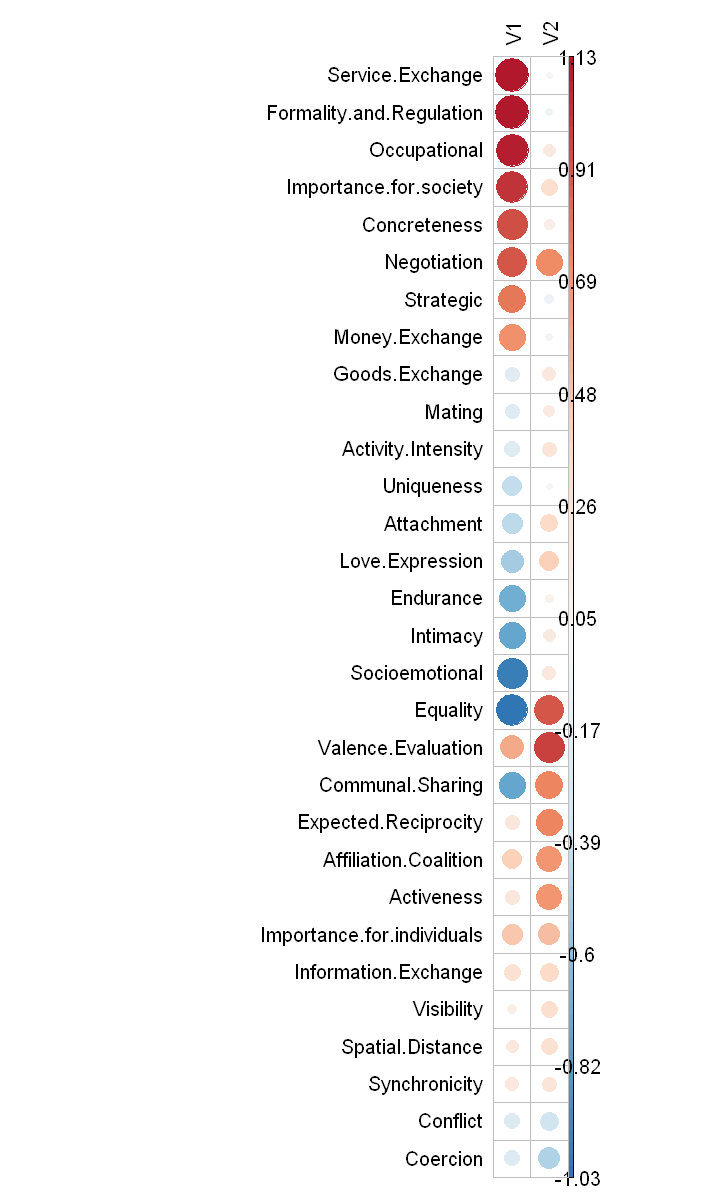

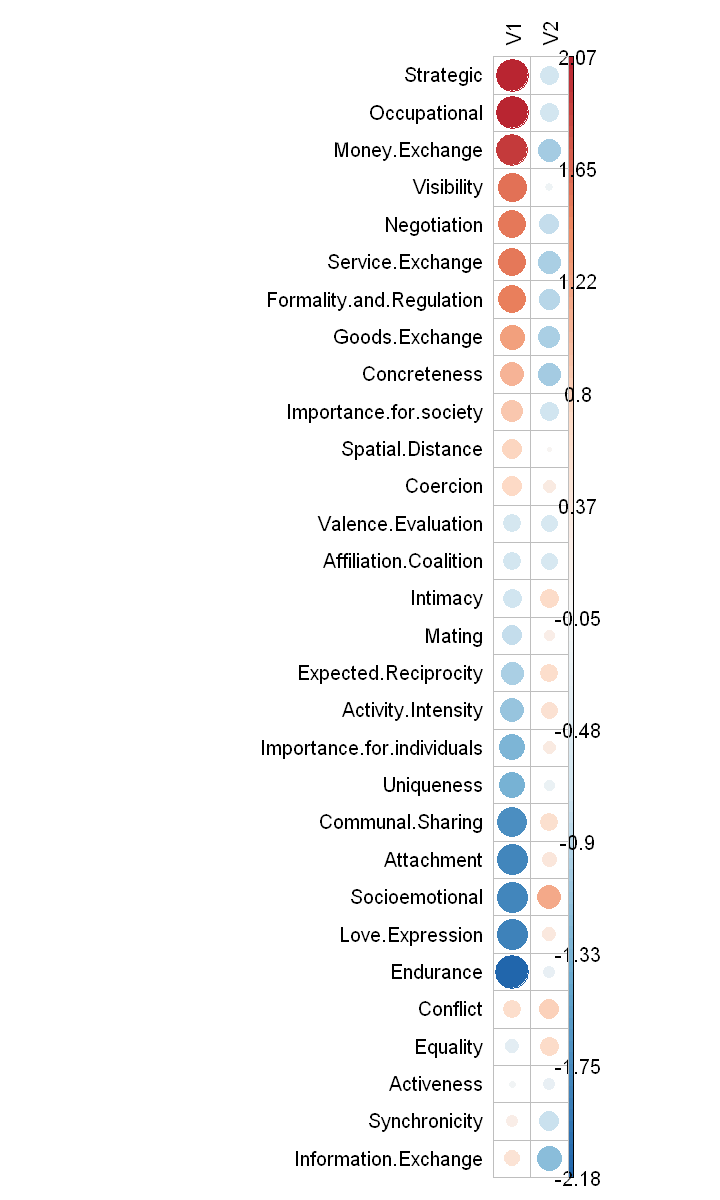

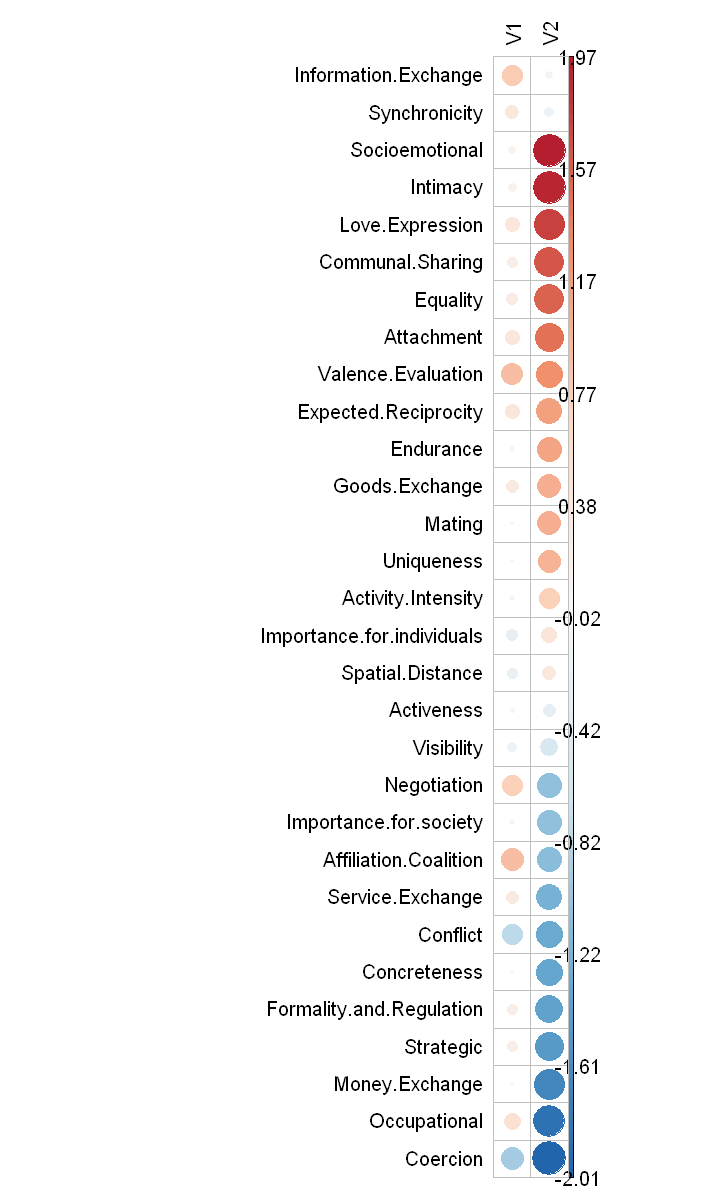

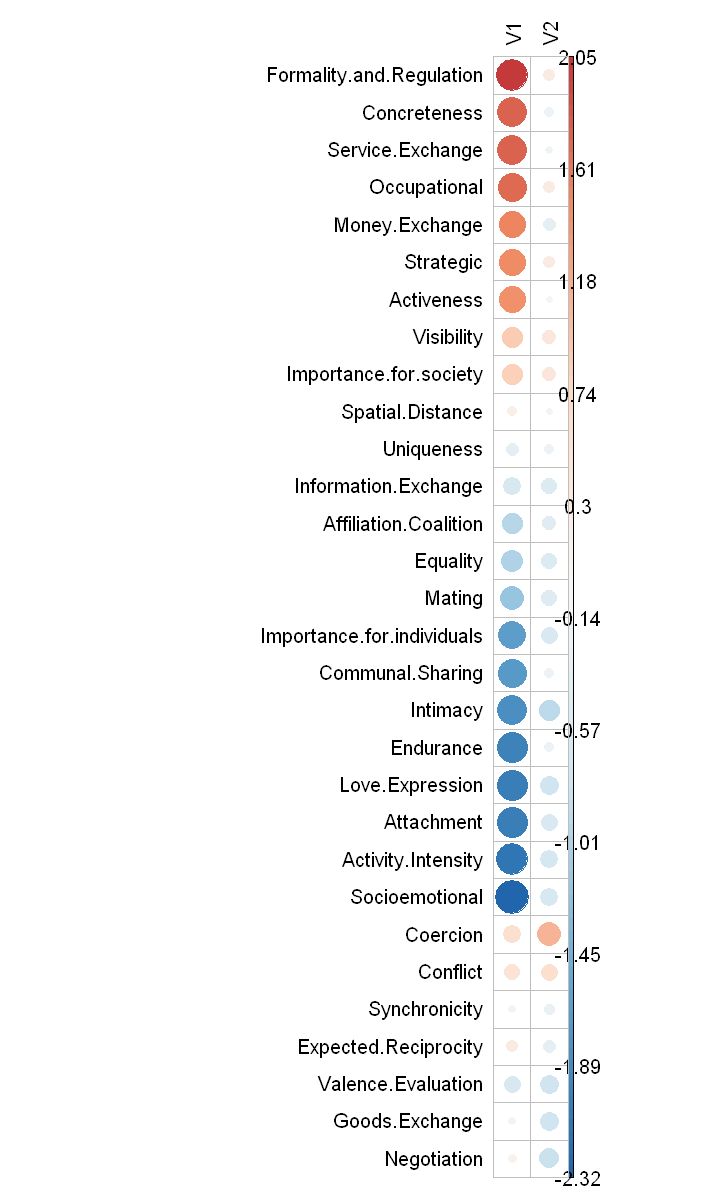

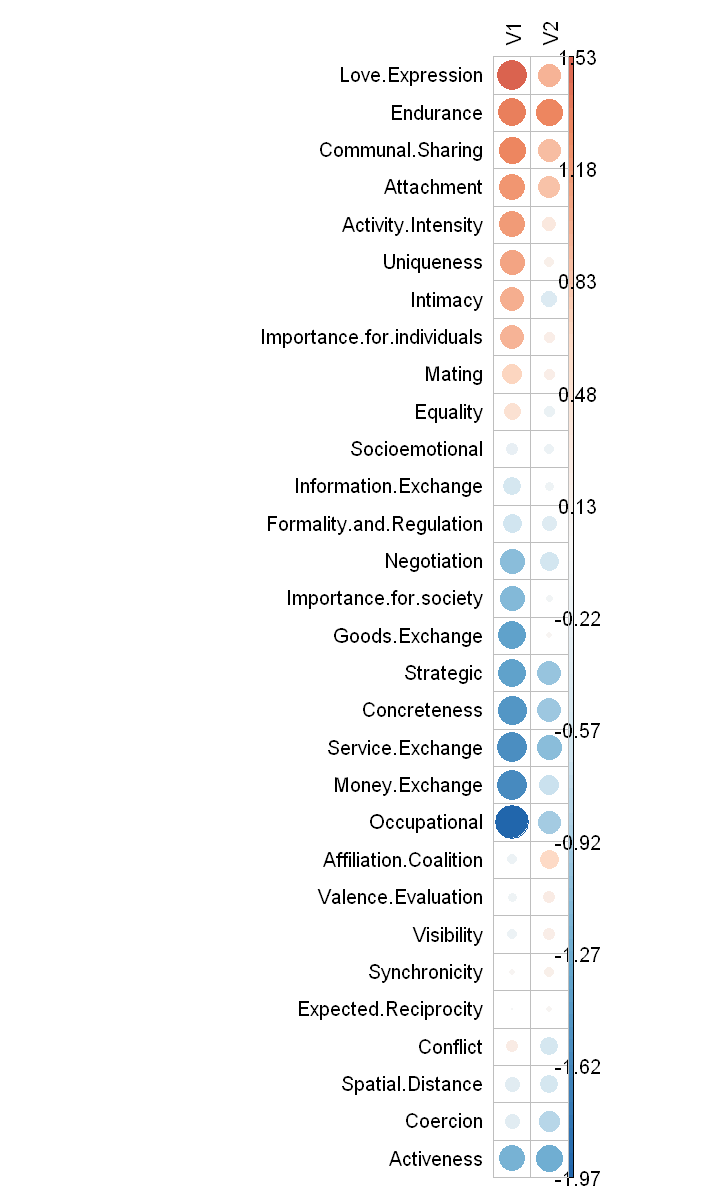

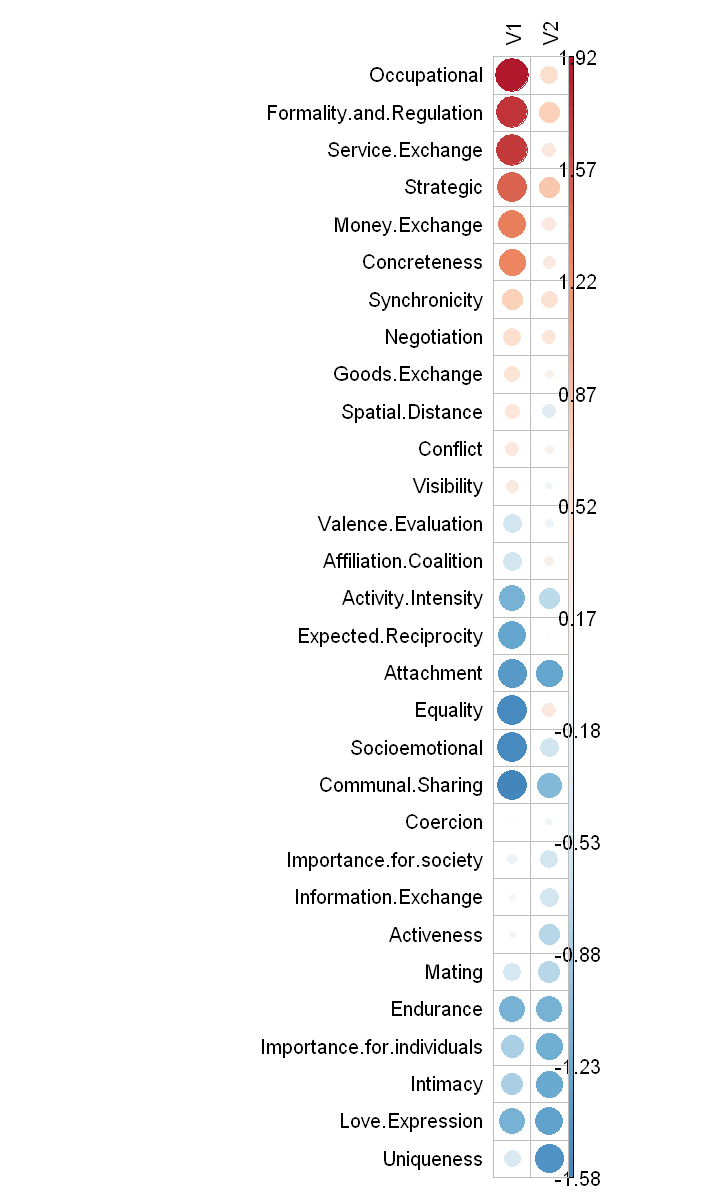

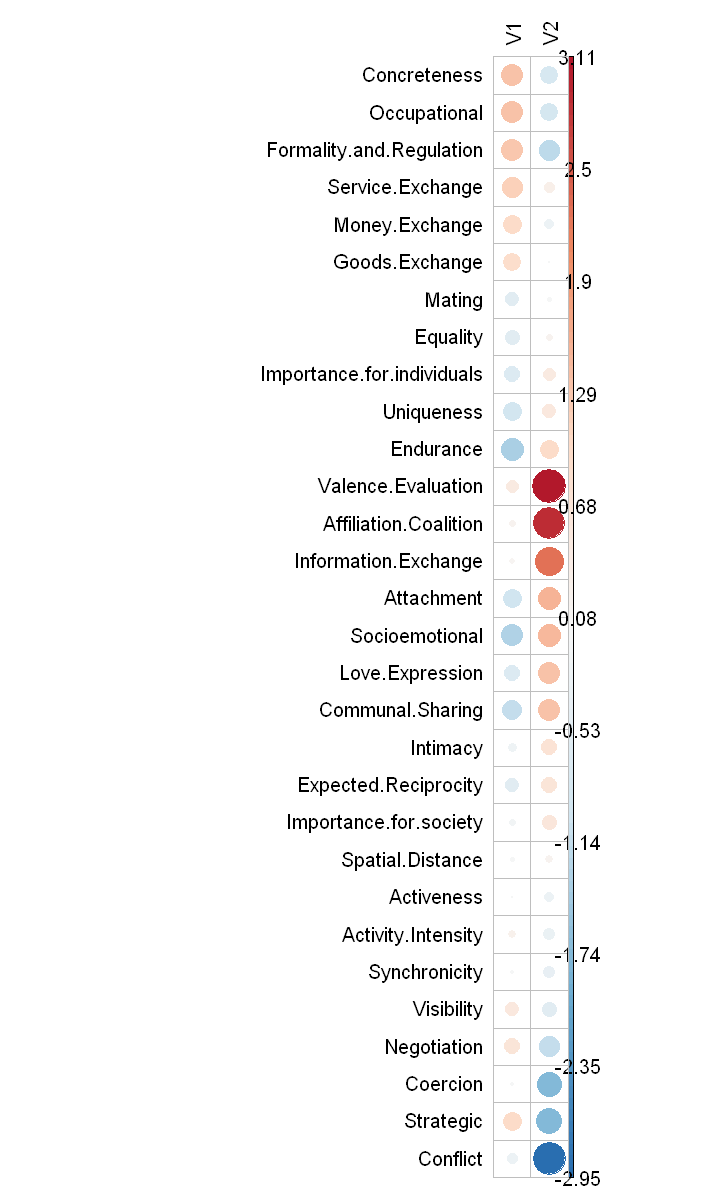

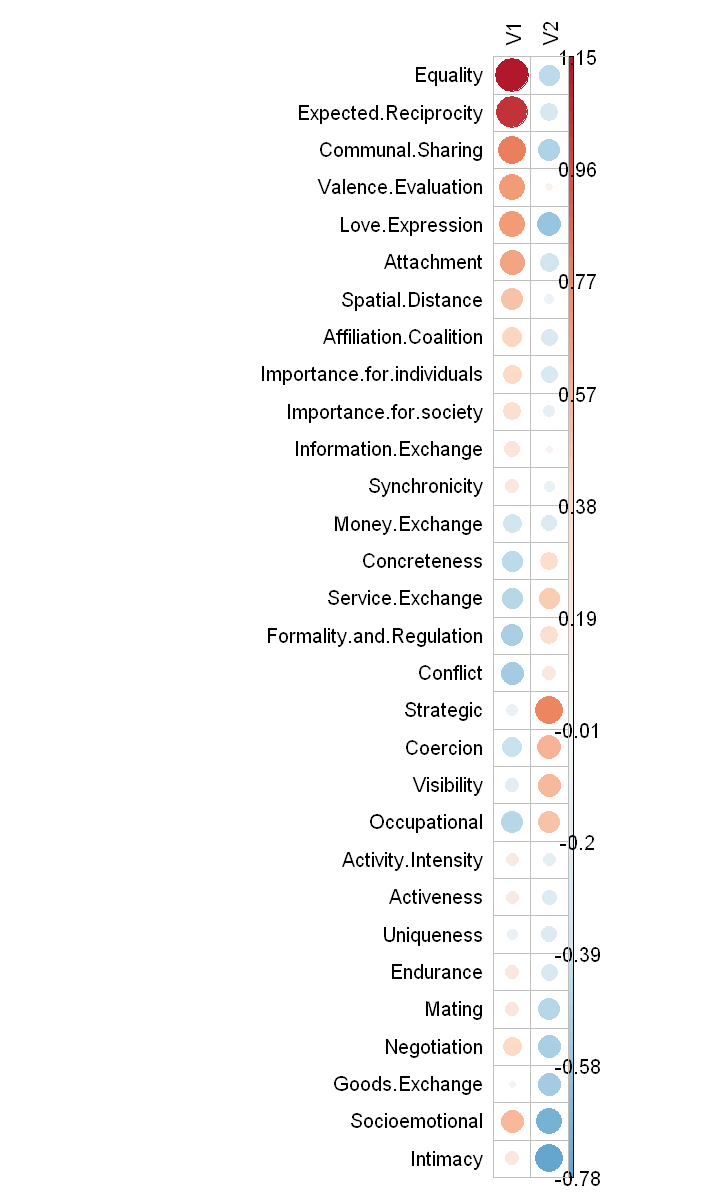

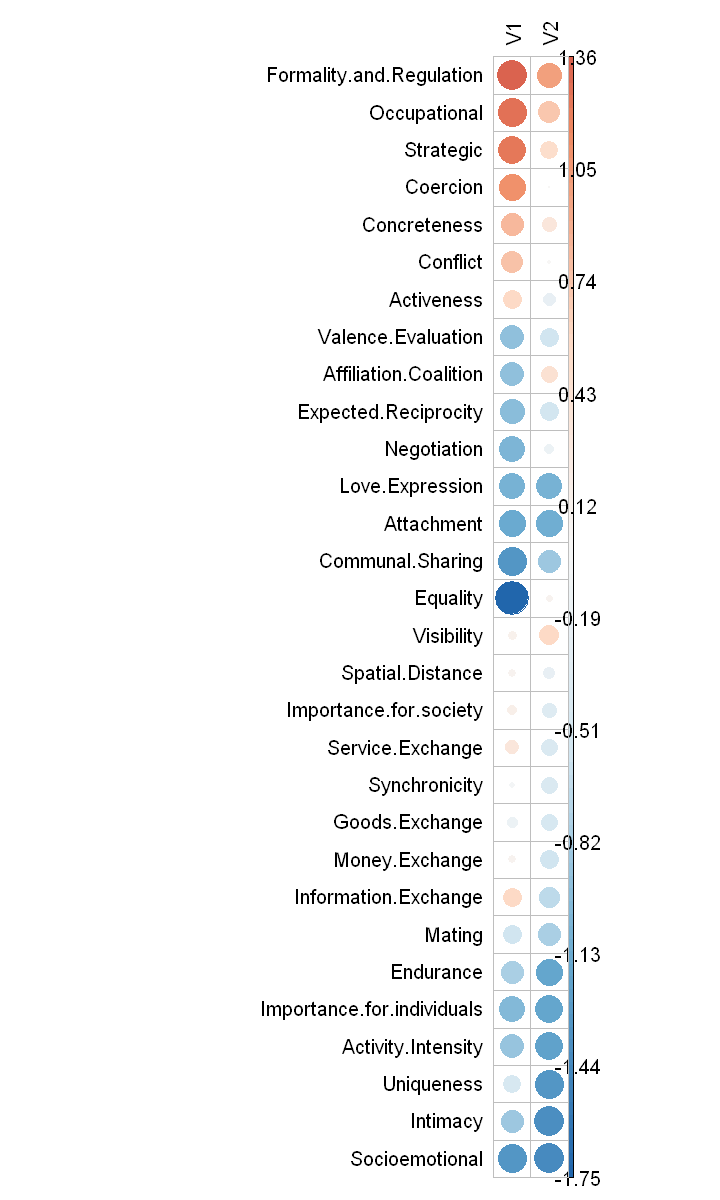

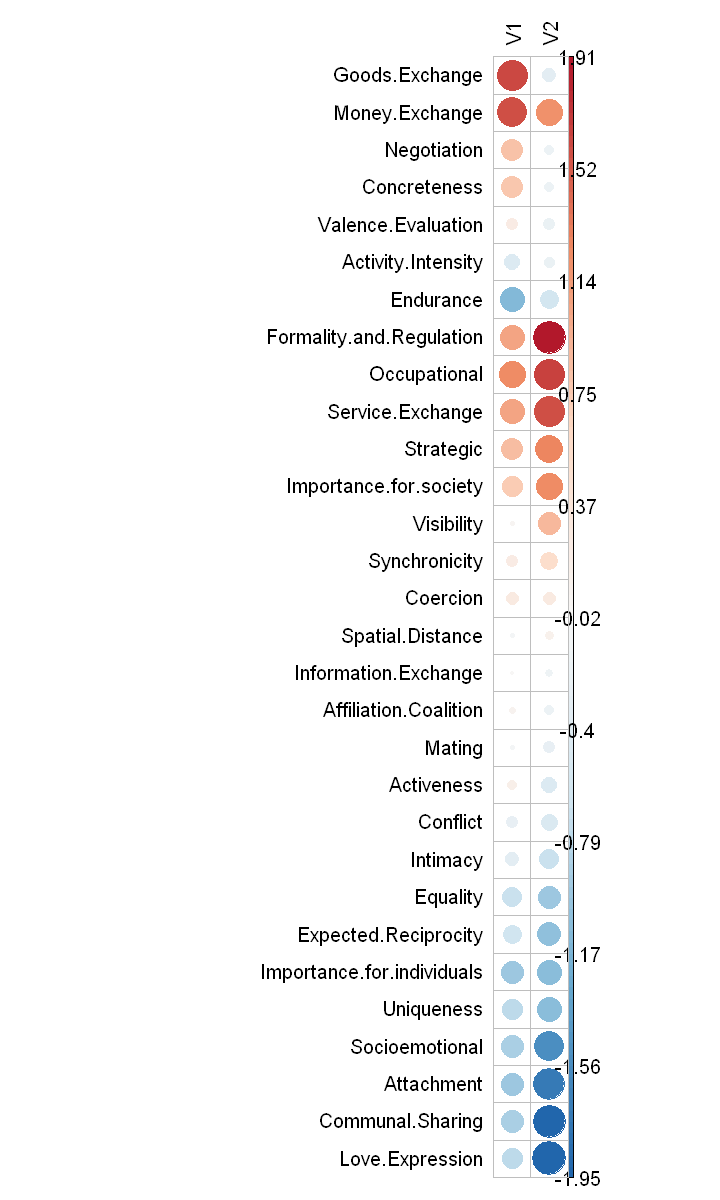

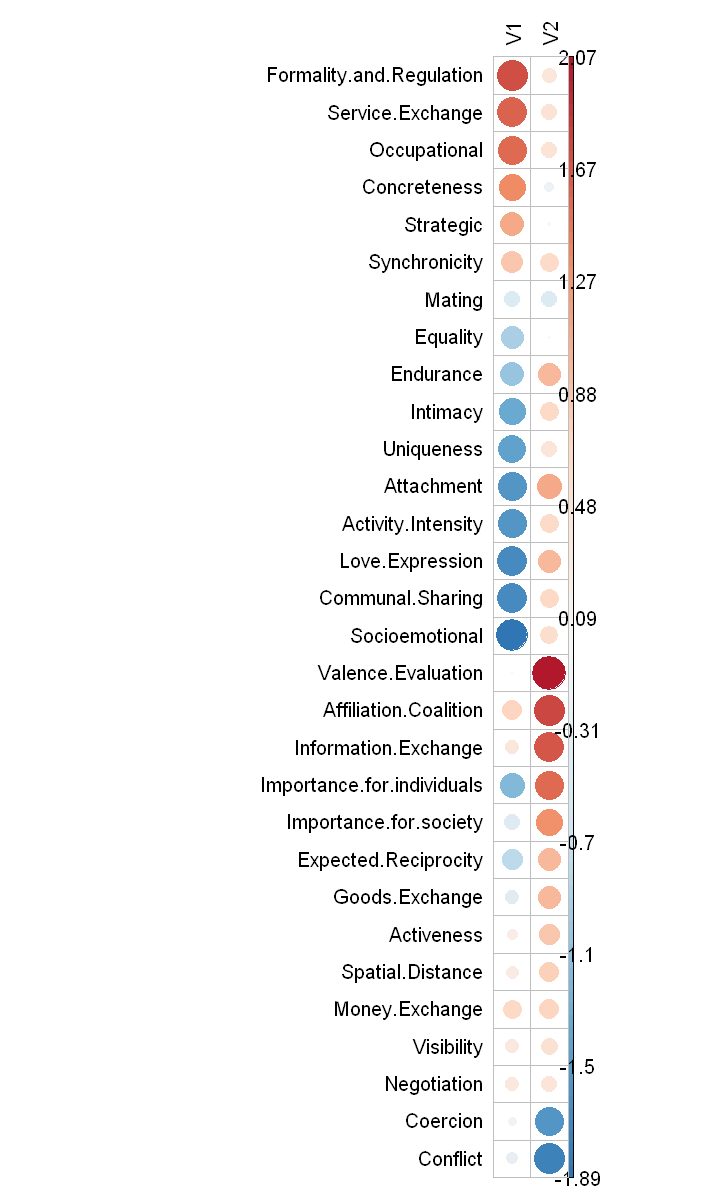

In [15]:
i=0
exp_subj_load_paths = c()
for (subj in subj_dim_list){
    i = i+1
    subj_list_path_temp = paste('output_data/individual/category/dimension_results/exp_mds_2V_ind/loading_score_none/',subj,sep='')
    exp_subj_load_paths[i] = subj_list_path_temp
}

paste(paste('Found',length(exp_subj_load_paths)),'subjects.')

for (f in exp_subj_load_paths){
   coe_df = read.csv(f,row.names=1)
   Plot_coefficient(coe_df,ndim=2,task='Explicit') 
}

# Implicit task

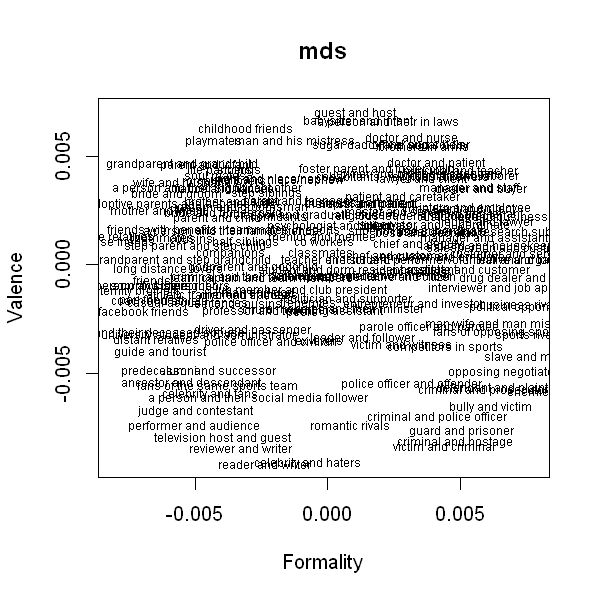

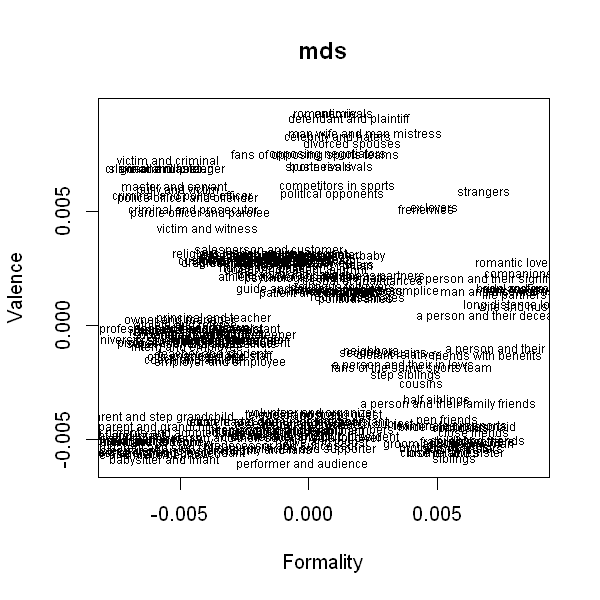

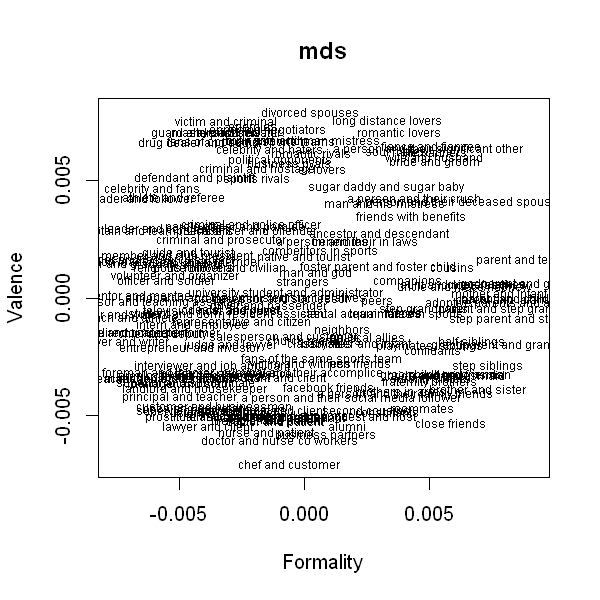

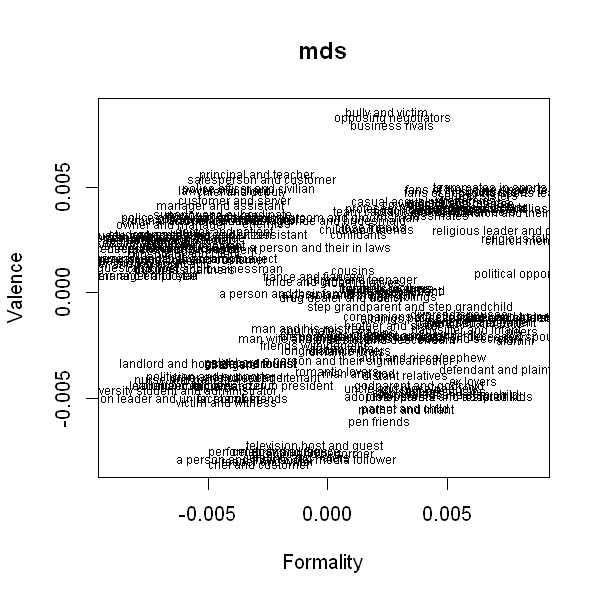

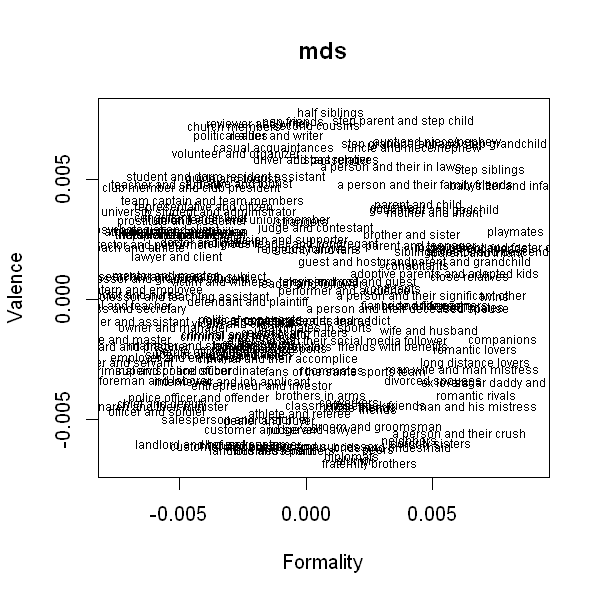

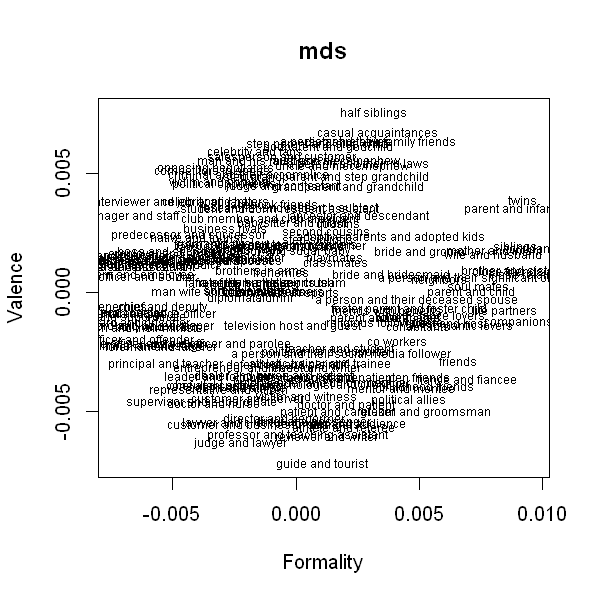

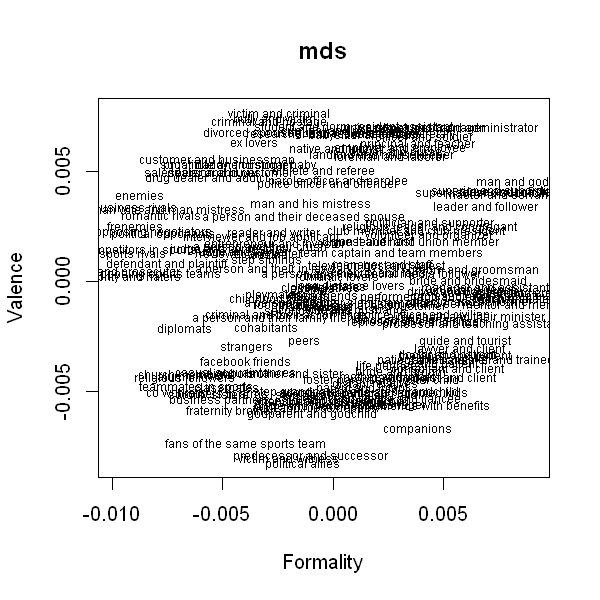

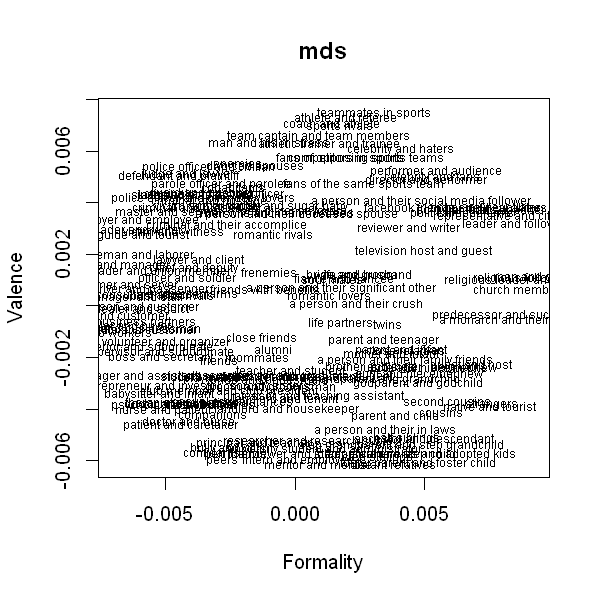

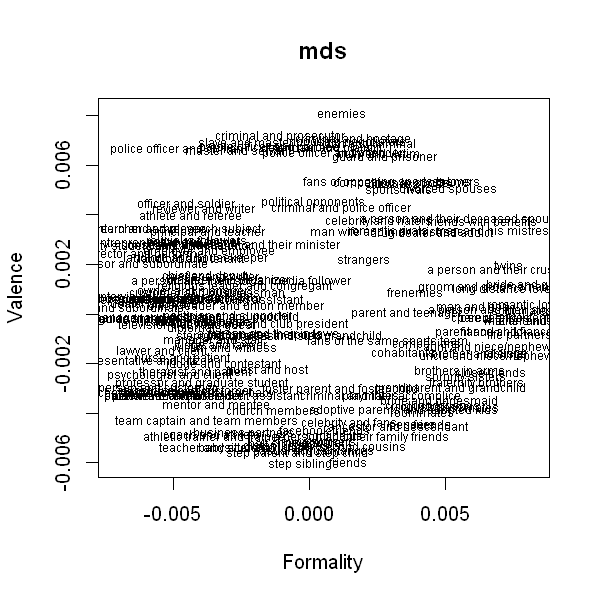

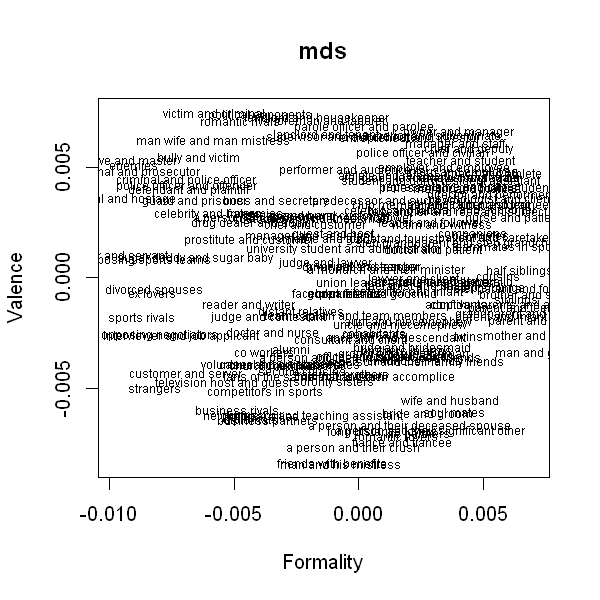

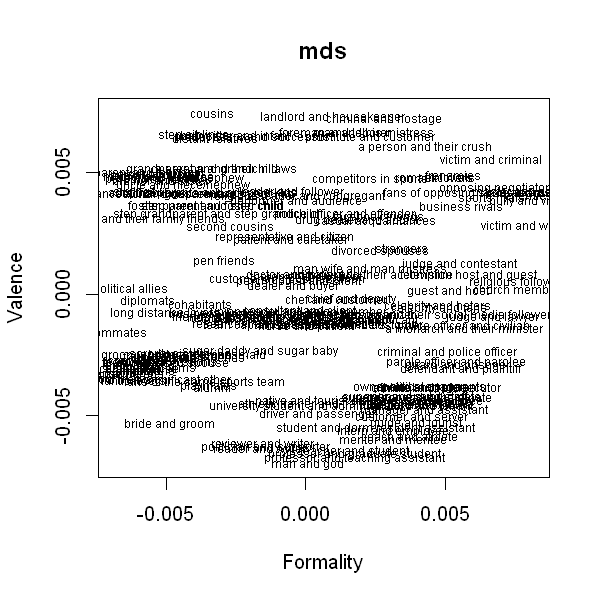

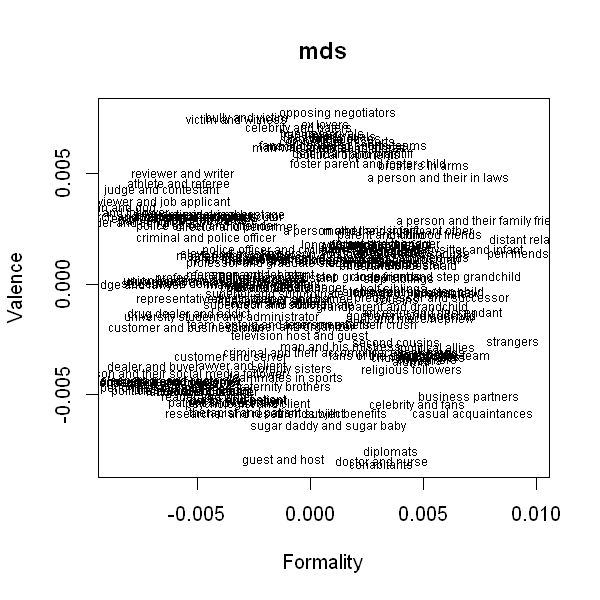

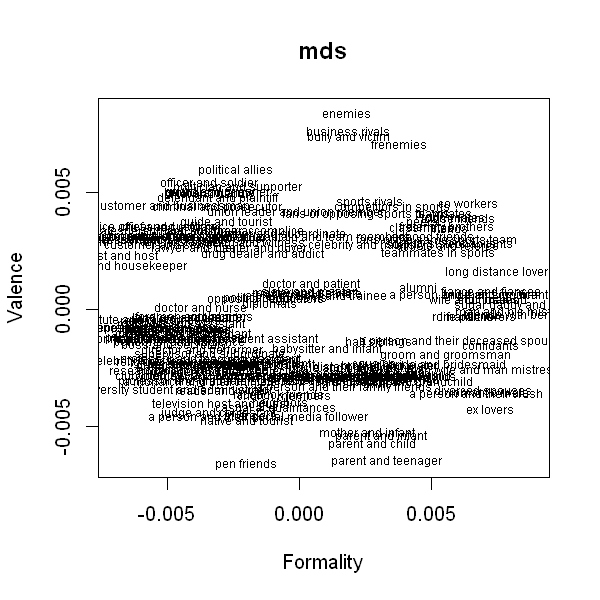

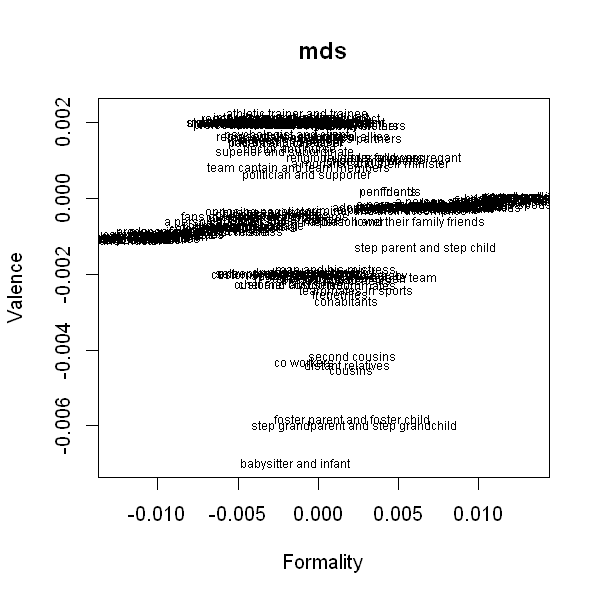

In [8]:
i = 0
for (f in imp_subj_paths){
    i = i+1
    imp_dissim = read.csv(f, row.names=1)
    DV_159 = read.csv(dim_subj_paths[i],row.names=1)
    
    mds_none = MDS_Regression(imp_dissim,DV_159,ndim=2,type_mds='mds')

    mds_coe_df = mds_none$coe_df
    mds_IV = mds_none$IV

    write.csv(mds_coe_df, file=paste('../../output_data/individual/category/dimension_results/imp_mds_2V_ind/loading_score_none/',subj_dim_list[i],sep=''))
    write.csv(mds_IV, file=paste('../../output_data/individual/category/dimension_results/imp_mds_2V_ind/relationship_score_none/',subj_dim_list[i],sep=''))
}

[1] "Found 14 subjects."

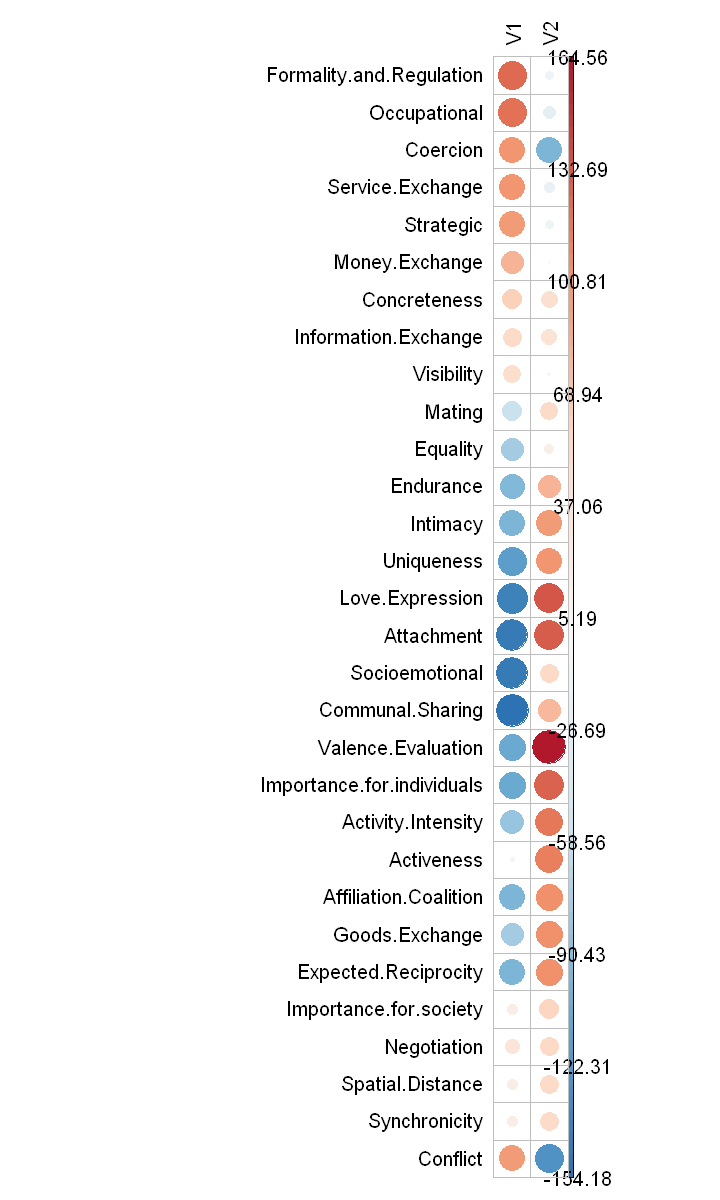

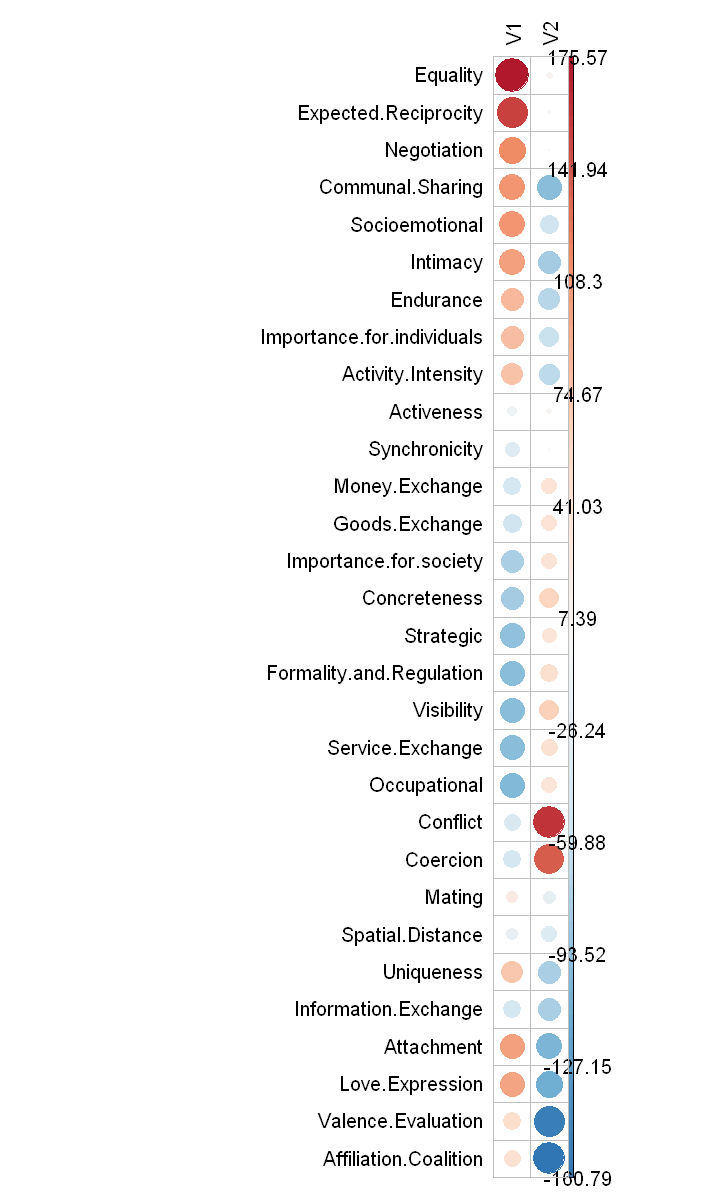

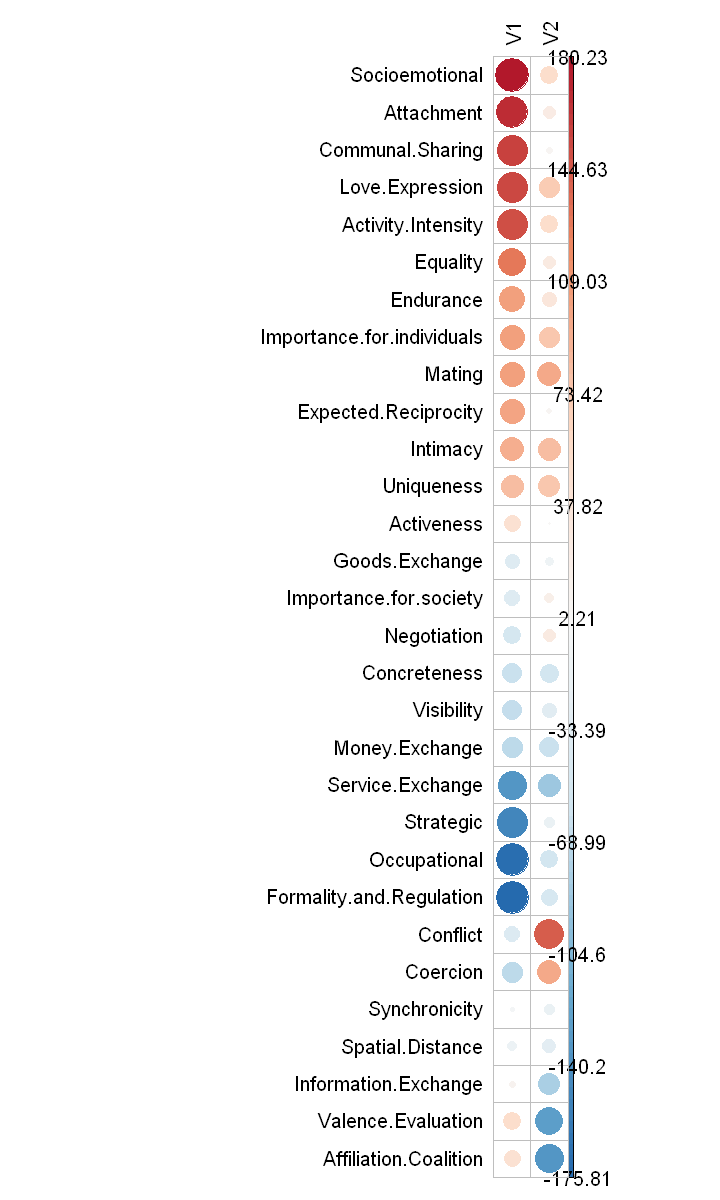

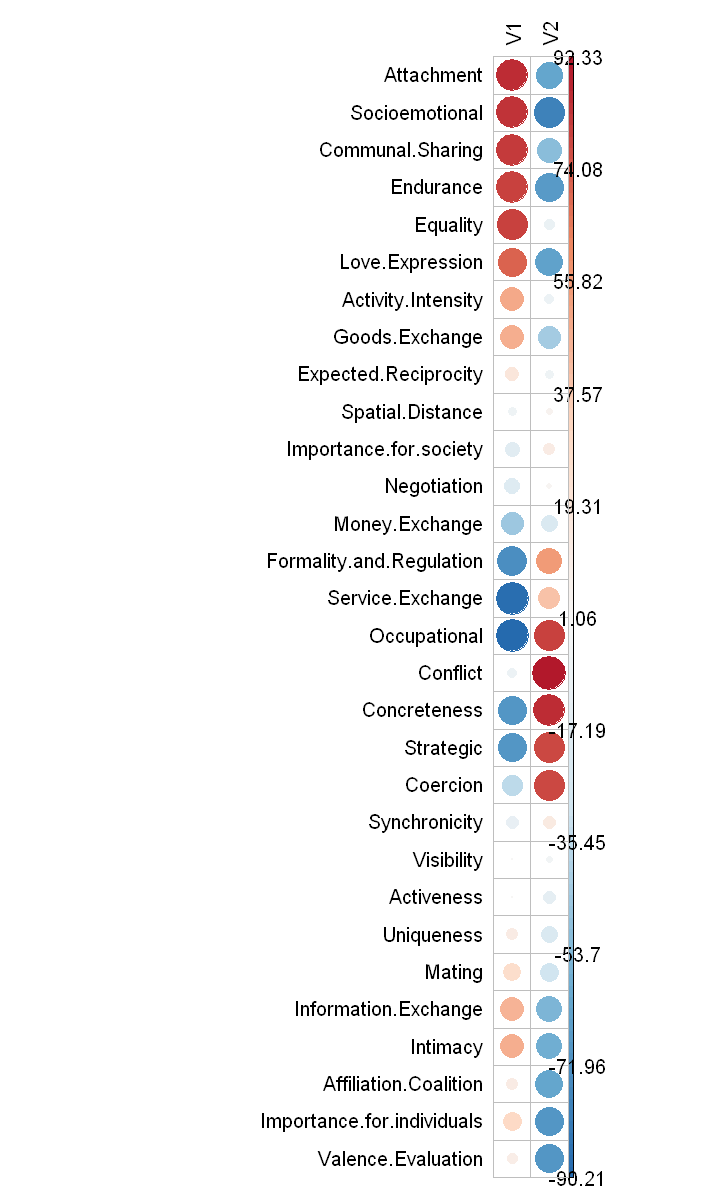

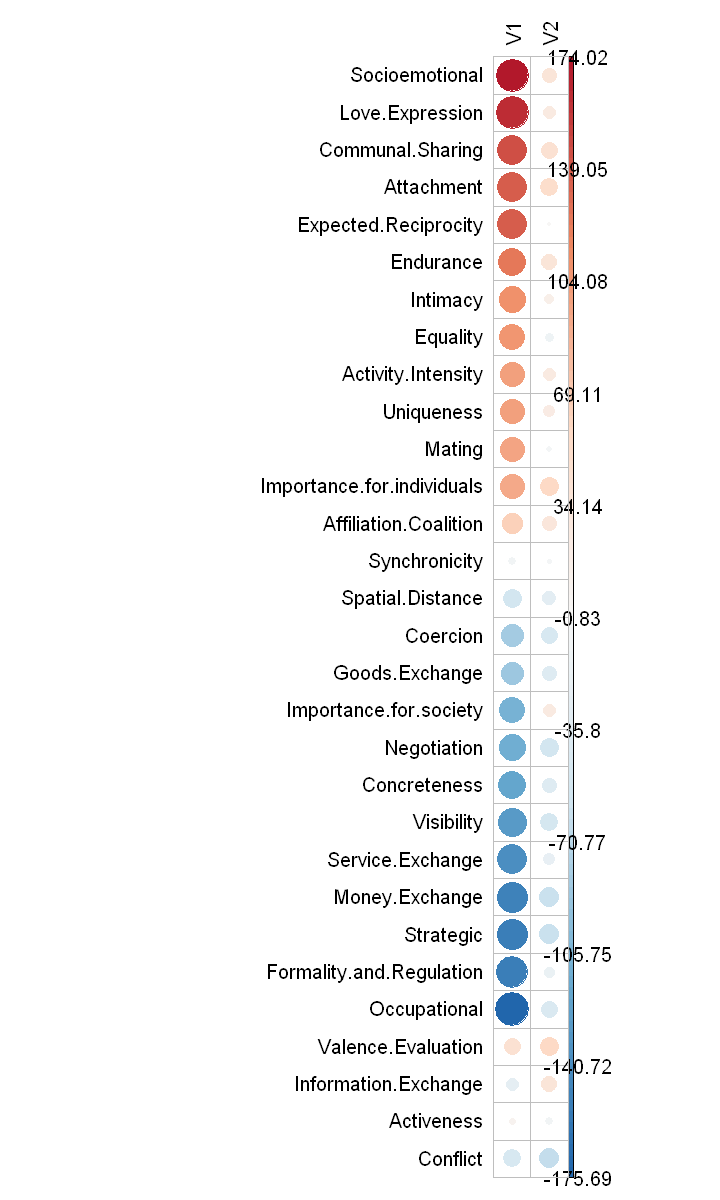

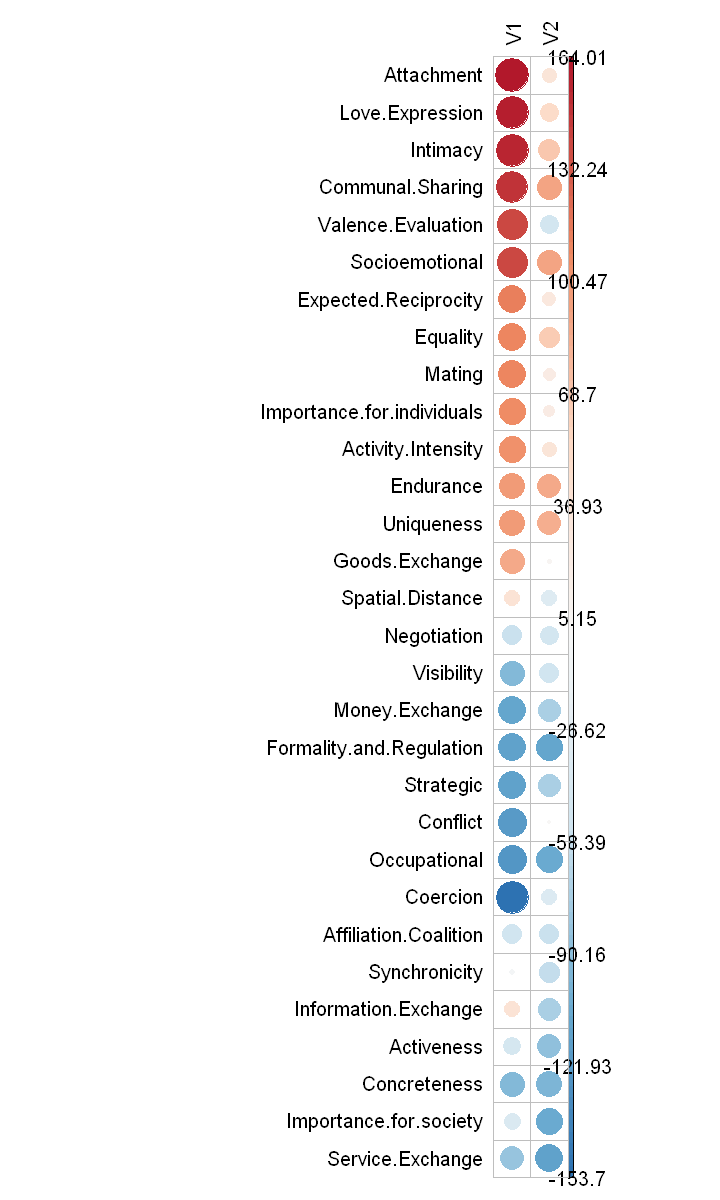

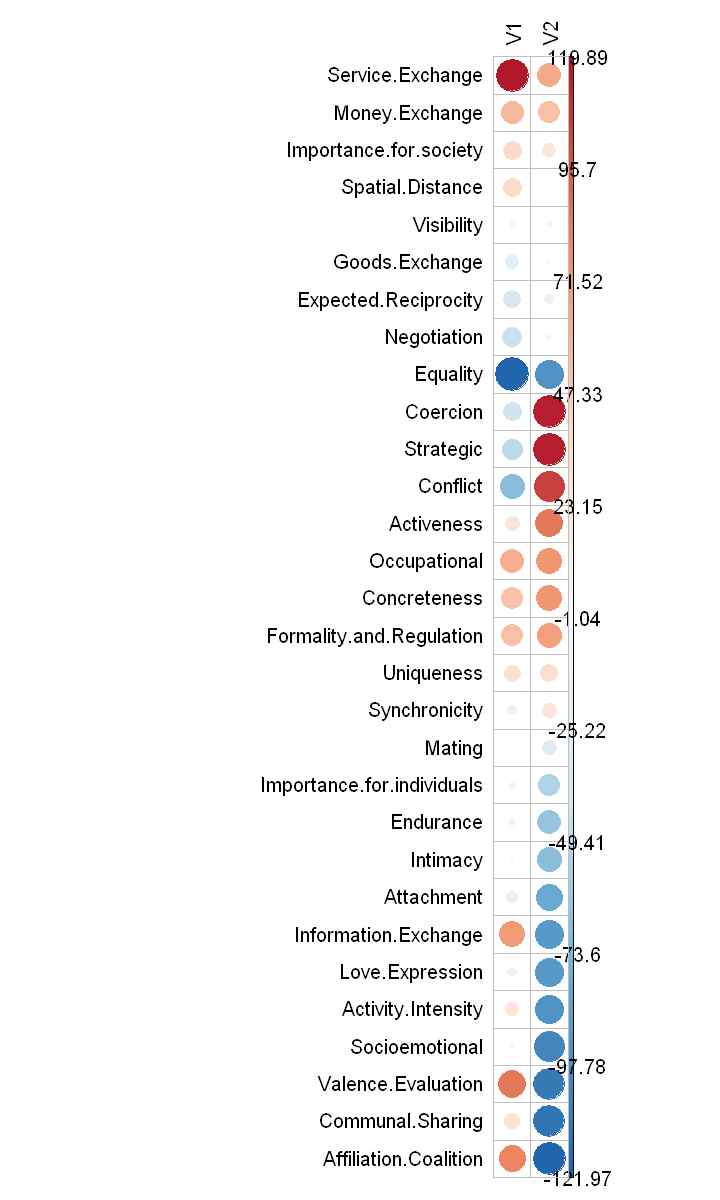

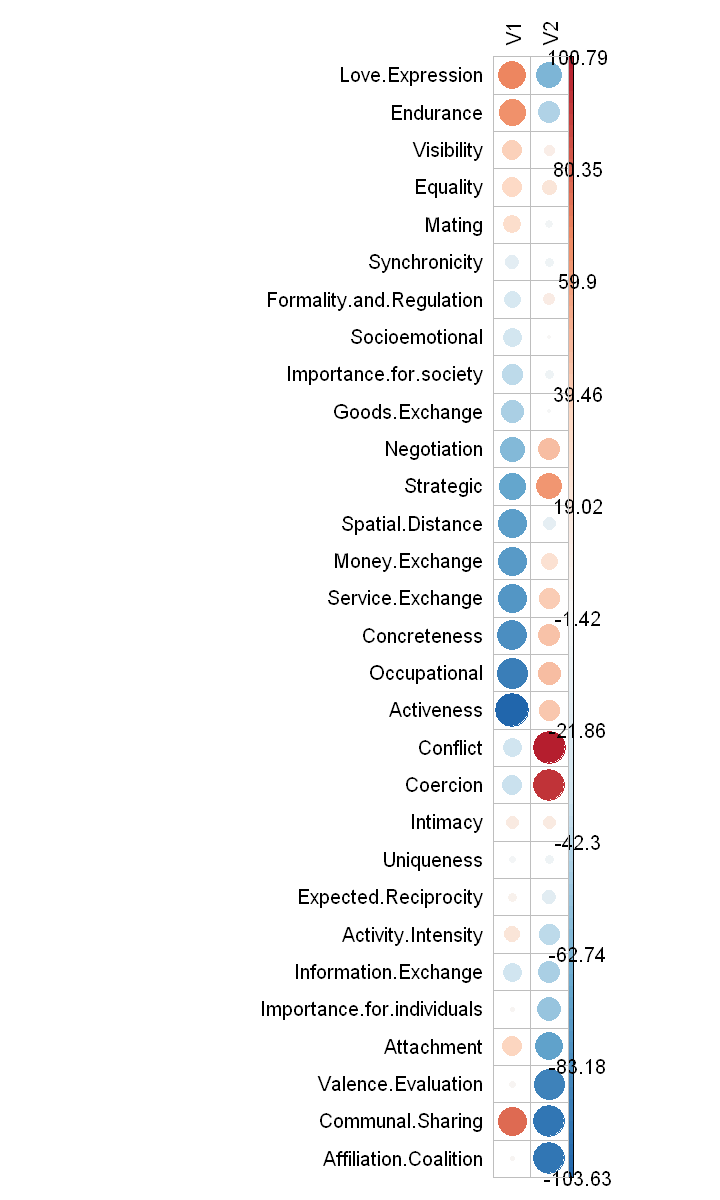

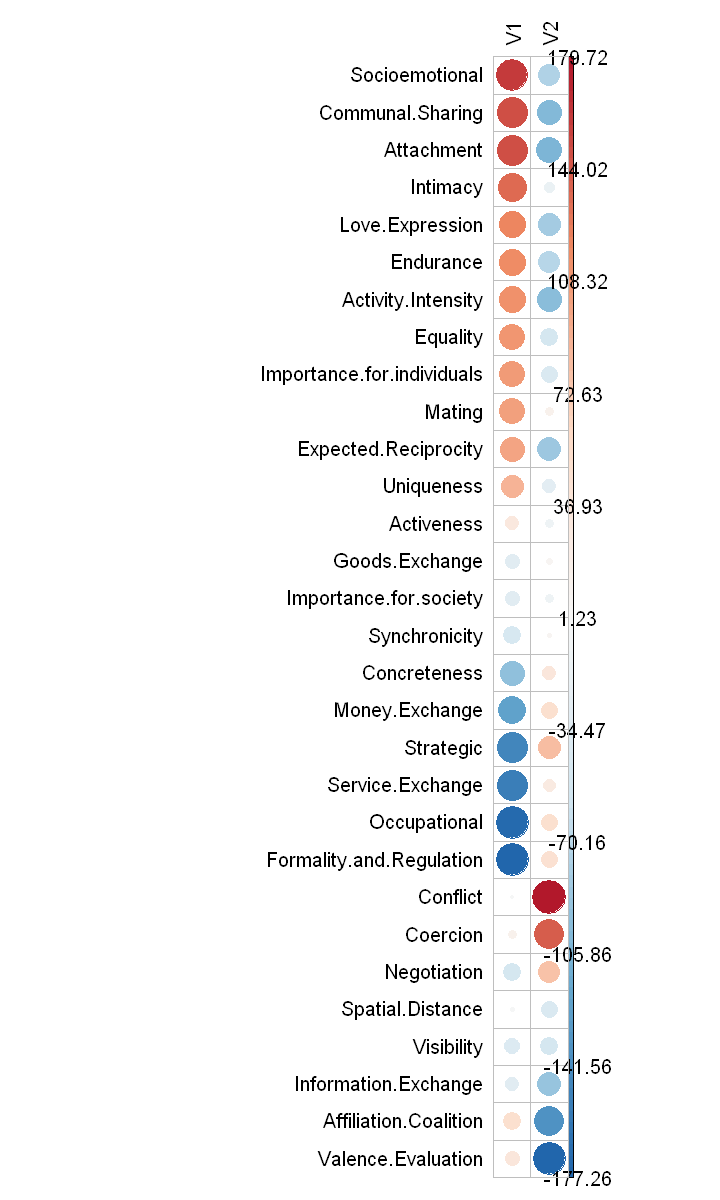

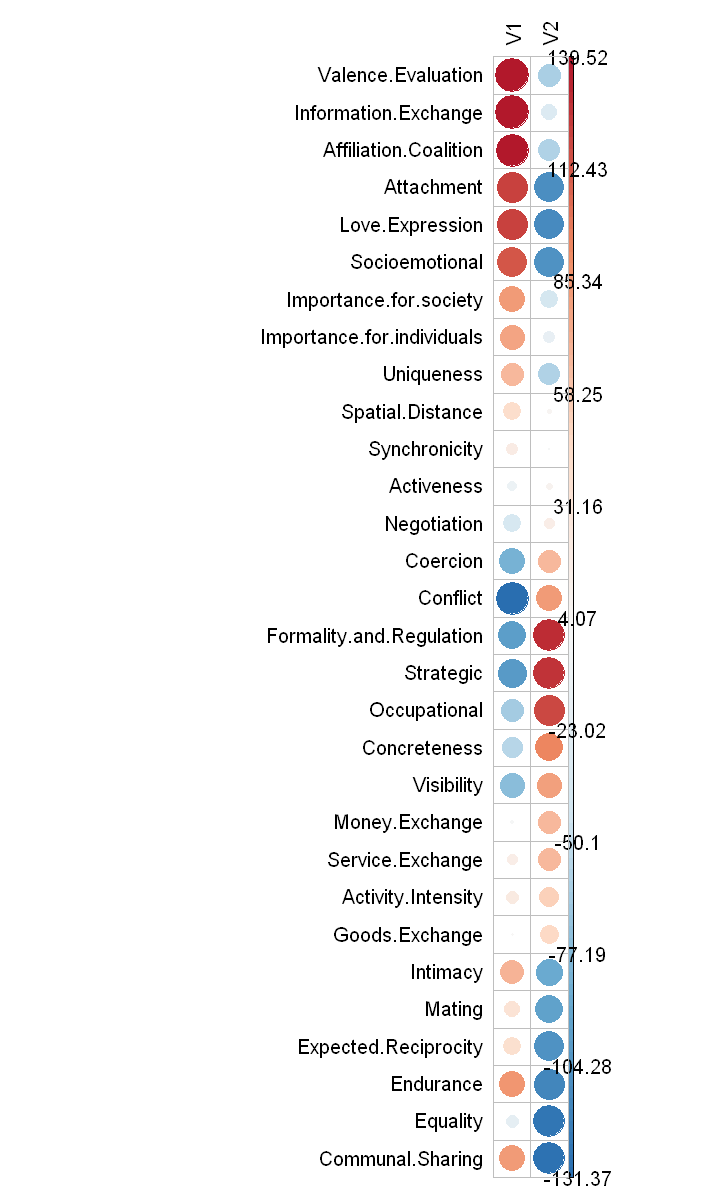

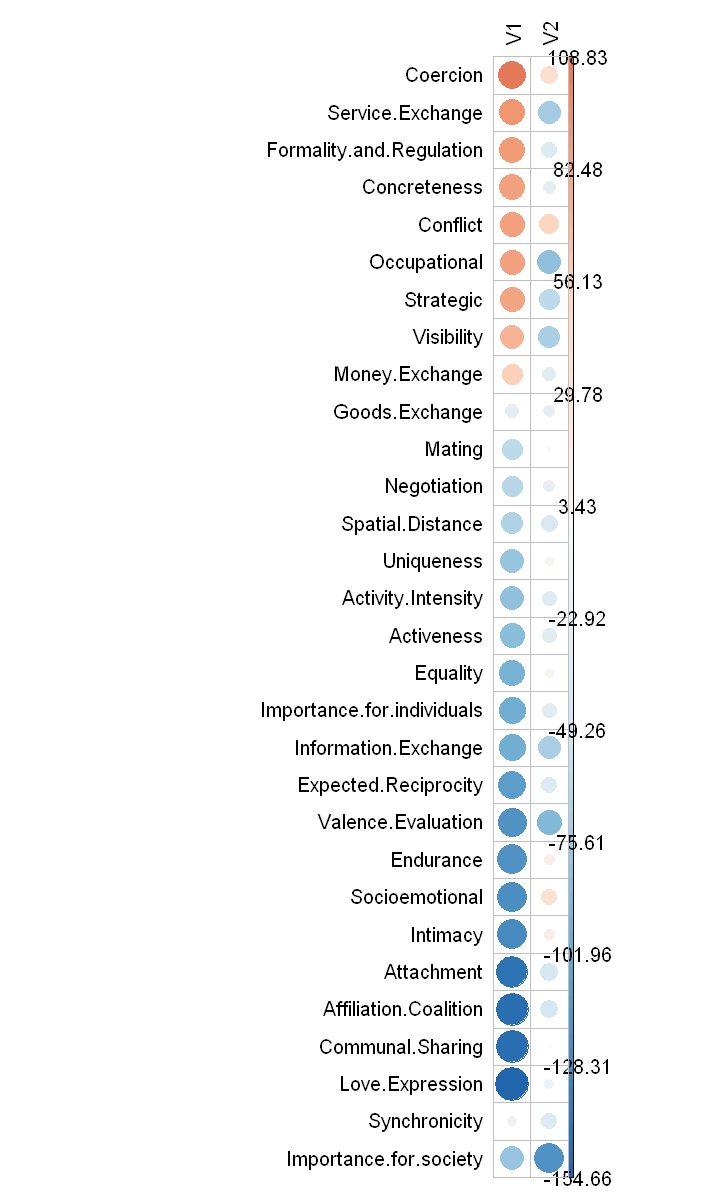

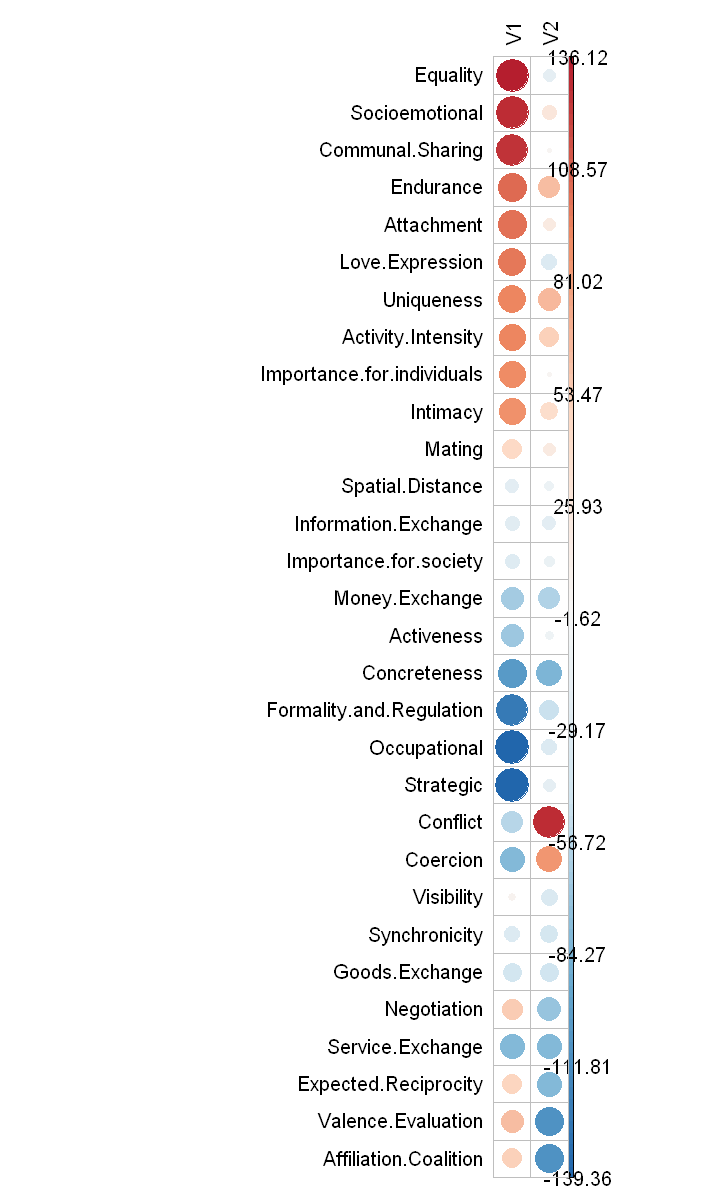

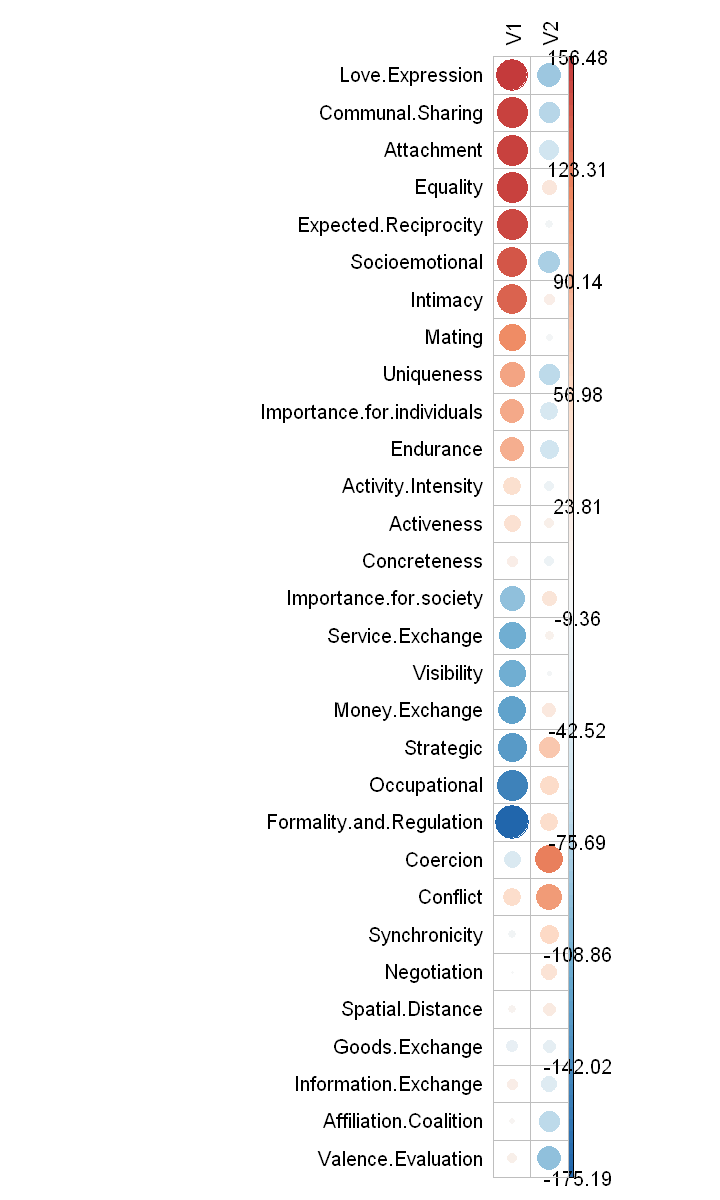

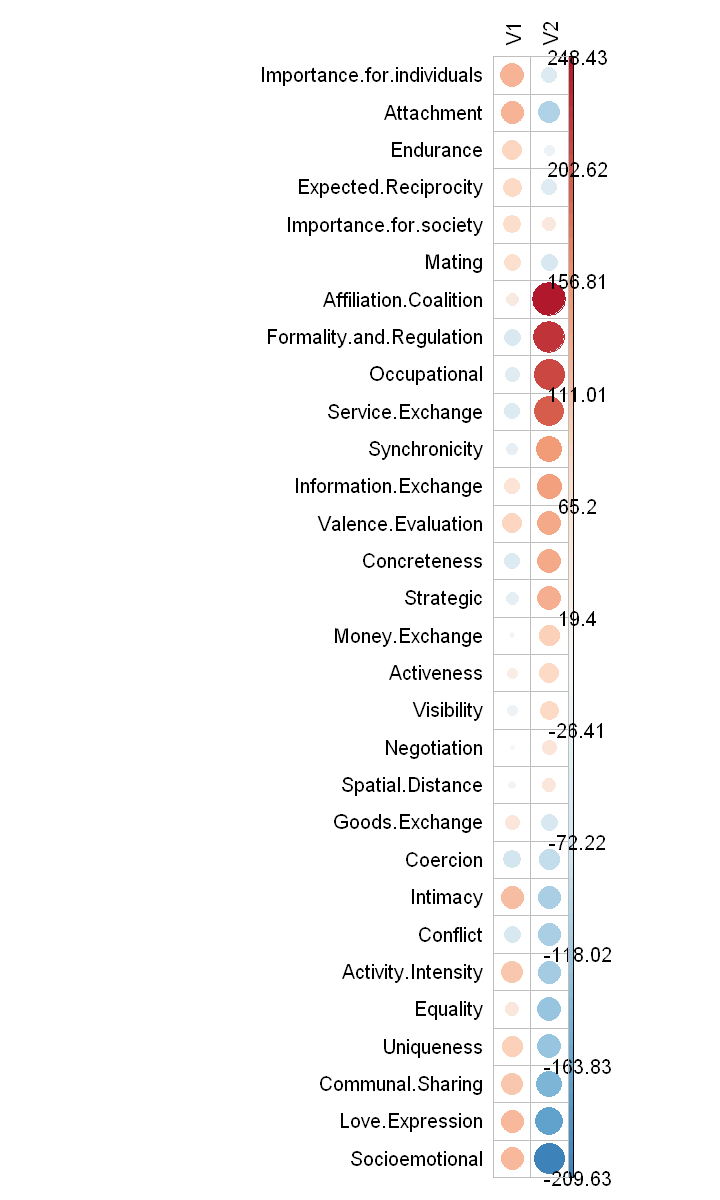

In [17]:
i=0
imp_subj_load_paths = c()
for (subj in subj_dim_list){
    i = i+1
    subj_list_path_temp = paste('output_data/individual/category/dimension_results/imp_mds_2V_ind/loading_score_none/',subj,sep='')
    imp_subj_load_paths[i] = subj_list_path_temp
}

paste(paste('Found',length(imp_subj_load_paths)),'subjects.')

for (f in imp_subj_load_paths){
   coe_df = read.csv(f,row.names=1)
   Plot_coefficient(coe_df,ndim=2,task='implicit') 
}